In [2]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt

# data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.graph_objects as go

# used for cohort analysis to calculate running period figures (order month - cohort month)
from operator import attrgetter

# machine learning libraries
from sklearn.preprocessing import StandardScaler

# forecasting libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import warnings

In [3]:
df_sales = pd.read_csv('SalesTransactionv4a-230918-164139.csv')

In [4]:
df_sales

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom
...,...,...,...,...,...,...,...,...
536345,C536548,12/1/2018,22168,Organiser Wood Antique White,18.96,-2,12472.0,Germany
536346,C536548,12/1/2018,21218,Red Spotty Biscuit Tin,14.09,-3,12472.0,Germany
536347,C536548,12/1/2018,20957,Porcelain Hanging Bell Small,11.74,-1,12472.0,Germany
536348,C536548,12/1/2018,22580,Advent Calendar Gingham Sack,16.35,-4,12472.0,Germany


# Data Cleansing

In [6]:
# 1. Change the Date column to datetime type
df_sales['Date']= pd.to_datetime(df_sales['Date'])

# 2. Remove all transactions that have negative quantity or whose TransactionNo starts with C.
df_sales = df_sales[df_sales['TransactionNo'].str[0]!='C']

df_sales = df_sales[(df_sales['Quantity'] > 0) & (df_sales['Price'] > 0)]

In [7]:
df_sales.isnull().sum()

TransactionNo    0
Date             0
ProductNo        0
ProductName      0
Price            0
Quantity         0
CustomerNo       1
Country          0
dtype: int64

# Top Contributing products

In a retail store, various types of products are sold.
Understanding the sales characteristics of each product is crucial.
Products with high customer demand are key to generating profits in the business.
On the other hand, products with low market demand can become a burden if the business stocks too many of them.

One segmentation method used is based on the following criteria:
- Transaction Volume: The number of transactions involving a product (regardless of the quantity of items per transaction).
- Total Revenue: The total dollar revenue generated from the sales of the product.

Create product segmentation based on volume and total revenue with the following rules:

The product segmentation based on volume and total revenue follows these rules:
1. Total revenue is defined as the product of the item's price and the total quantity sold.
2. The top 20% of products by transaction volume are classified as "Popular". Products within the 20-80% range are categorized as "Normal", while the remaining products fall into the "Low" category.
3. The top 20% of products by total revenue are classified as "Popular". Products within the 20-80% range are categorized as "Normal", while the rest are in the "Low" category.
4. Based on the combined segmentation from points 2 and 3:
- If a product is Popular in both transaction volume and total revenue, it is classified as "Super Popular".
- If one attribute is Popular while the other is Normal, the final classification is "Popular".
- If both attributes are Low, the final classification is "Low".
- Any other combination falls into the "Normal" category.

### 1. Adding total_revenue column

In [10]:
df_sales['total_revenue'] = df_sales['Price'] * df_sales['Quantity']
df_sales

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,total_revenue
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,257.64
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,383.40
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,138.36
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,127.80
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,71.64
...,...,...,...,...,...,...,...,...,...
536320,536585,2018-12-01,37449,Ceramic Cake Stand + Hanging Cakes,20.45,2,17460.0,United Kingdom,40.90
536321,536590,2018-12-01,22776,Sweetheart 3 Tier Cake Stand,20.45,1,13065.0,United Kingdom,20.45
536322,536590,2018-12-01,22622,Box Of Vintage Alphabet Blocks,20.45,2,13065.0,United Kingdom,40.90
536323,536591,2018-12-01,37449,Ceramic Cake Stand + Hanging Cakes,20.45,1,14606.0,United Kingdom,20.45


### 2. 20% of products with the highest transaction volume fall into the "Popular" category. 20-80% fall into the "Normal" category and the rest fall into the "Low" category.

In [12]:
# Step 1: Groupby ProductName and calculate sum Quantity per ProductName
product_quantity = df_sales.groupby('ProductName')['Quantity'].sum().reset_index()

# Step 2: Sort the sum quantity from largest to smallest
product_quantity = product_quantity.sort_values('Quantity', ascending=False).reset_index()

# Step 3: Define limits for transaction volume categories
total_products = len(product_quantity) # Calculate the total number of product rows in the product_quantity dataset
popular_limit = int(total_products * 0.2)  # Define index limits for the "Popular" category (top 20% of products)
normal_limit = int(total_products * 0.8)  # Determine the index limit for the "Normal" category (top 21% - 80% of products)

# Step 4: Define a function to categorize transaction volume with previously created limits.
def assign_category_by_index(index):
    if index < popular_limit:
        return "Popular"
    elif index < normal_limit:
        return "Normal"
    else:
        return "Low"

# Step 5: Apply the assign_category_by_index function to the Category column product_quantity table
product_quantity['Category'] = product_quantity.index.map(assign_category_by_index)

product_quantity = product_quantity.drop(columns = ['index'])

product_quantity

,ProductName,Quantity,Category
0,Paper Craft Little Birdie,80995,Popular
1,Medium Ceramic Top Storage Jar,78033,Popular
2,Popcorn Holder,56921,Popular
3,World War 2 Gliders Asstd Designs,55047,Popular
4,Jumbo Bag Red Retrospot,48478,Popular
...,...,...,...
3748,Orange/Fuschia Stones Necklace,1,Low
3749,Blue New Baroque Flock Candlestick,1,Low
3750,Green Pendant Shell Necklace,1,Low
3751,Vintage Bead Pink Jewel Stand,1,Low


### 3. 20% of products with the highest total revenue are in the "Popular" category. 20 - 80% are in the "Normal" category and the rest are in the "Low" category.

In [14]:
# Step 1: Groupby ProductName and calculate sum total_revenue per ProductName
product_revenue = df_sales.groupby('ProductName')['total_revenue'].sum().reset_index()

# Step 2: Sort the total revenue sum from largest to smallest.
product_revenue = product_revenue.sort_values('total_revenue', ascending=False).reset_index()

# Step 3: Define limits for total revenue categories
total_products = len(product_quantity) # Calculate the total number of product rows in the product_quantity dataset
popular_limit = int(total_products * 0.2)  # Define index limits for the "Popular" category (top 20% of products)
normal_limit = int(total_products * 0.8)  # Determine the index limit for the "Normal" category (top 80% of products)

# Step 4: Define function to categorize total revenue
def assign_revenue_category_by_index(index):
    if index < popular_limit:
        return "Popular"
    elif index < normal_limit:
        return "Normal"
    else:
        return "Low"

# Step 5: Apply function assign_revenue_category_by_index to product_revenue table Category column
product_revenue['Category'] = product_revenue.index.map(assign_revenue_category_by_index)

product_revenue = product_revenue.drop(columns = ['index'])

product_revenue

,ProductName,total_revenue,Category
0,Paper Craft Little Birdie,1002718.10,Popular
1,Medium Ceramic Top Storage Jar,881990.18,Popular
2,Popcorn Holder,587433.94,Popular
3,World War 2 Gliders Asstd Designs,569735.39,Popular
4,Cream Hanging Heart T-Light Holder,484592.69,Popular
...,...,...,...
3748,Dusty Pink Christmas Tree 30cm,11.53,Low
3749,Pink Crystal Guitar Phone Charm,11.12,Low
3750,Hen House W Chick In Nest,10.68,Low
3751,Set 10 Cards Snowy Robin 17099,6.19,Low


### 4. Based on the combined segmentation from points 2 and 3, if a product is classified as **Popular** in both transaction volume and total revenue, its final segmentation will be **"Super Popular."** If one attribute is **Popular** while the other is **Normal**, the final segmentation will be **"Popular."** If both attributes are **Low**, the final segmentation will be **"Low."** All other combinations fall into the **"Normal"** category.

In [16]:
# Merge product_quantity and product_revenue with the ProductName column as the merge reference
merged_segmentation = pd.merge(product_quantity, product_revenue, on='ProductName', suffixes=('_quantity', '_revenue'))

# Define function for product segmentation after merging
def final_segmentation(row):
    if row['Category_quantity'] == 'Popular' and row['Category_revenue'] == 'Popular':
        return 'Super Popular'
    elif (row['Category_quantity'] == 'Popular' and row['Category_revenue'] == 'Normal') or \
         (row['Category_quantity'] == 'Normal' and row['Category_revenue'] == 'Popular'):
        return 'Popular'
    elif row['Category_quantity'] == 'Low' and row['Category_revenue'] == 'Low':
        return 'Low'
    else:
        return 'Normal'

#Apply the final_segmentation function to the merged_segmentation table.
merged_segmentation['final_product_segmentation'] = merged_segmentation.apply(final_segmentation, axis=1)

merged_segmentation

,ProductName,Quantity,Category_quantity,total_revenue,Category_revenue,final_product_segmentation
0,Paper Craft Little Birdie,80995,Popular,1002718.10,Popular,Super Popular
1,Medium Ceramic Top Storage Jar,78033,Popular,881990.18,Popular,Super Popular
2,Popcorn Holder,56921,Popular,587433.94,Popular,Super Popular
3,World War 2 Gliders Asstd Designs,55047,Popular,569735.39,Popular,Super Popular
4,Jumbo Bag Red Retrospot,48478,Popular,297205.04,Popular,Super Popular
...,...,...,...,...,...,...
3748,Orange/Fuschia Stones Necklace,1,Low,15.35,Low,Low
3749,Blue New Baroque Flock Candlestick,1,Low,15.02,Low,Low
3750,Green Pendant Shell Necklace,1,Low,15.47,Low,Low
3751,Vintage Bead Pink Jewel Stand,1,Low,15.32,Low,Low


C:\Users\benny\AppData\Local\Temp\ipykernel_16128\2935488735.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_segmentation, x='final_product_segmentation', palette="cividis")


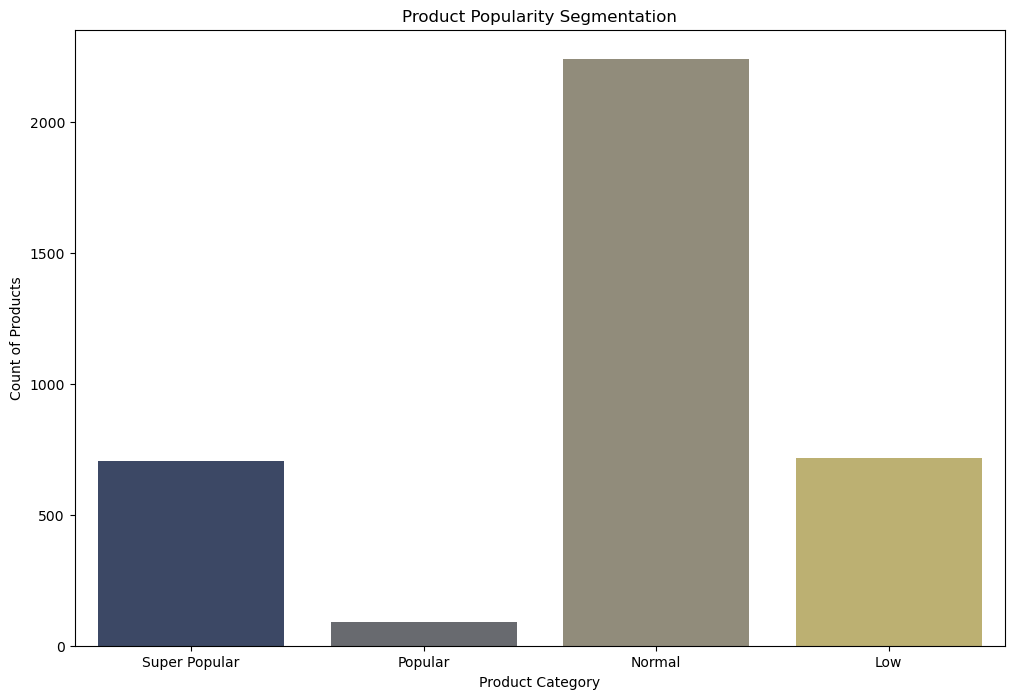

In [17]:
# Visualization
plt.figure(figsize=(12, 8))
sns.countplot(data=merged_segmentation, x='final_product_segmentation', palette="cividis")
plt.title("Product Popularity Segmentation")
plt.xlabel("Product Category")
plt.ylabel("Count of Products")
plt.show()

In [18]:
merged_segmentation['final_product_segmentation'].value_counts()

final_product_segmentation
Normal           2241
Low               717
Super Popular     705
Popular            90
Name: count, dtype: int64

# Cohort Analysis - Customer Retention Rate

Cohort analysis is an analytical method used to study the behavior of consumers or users within the same group over a specific period.
Example of a Cohort: Customers who joined in May.

Retention analysis is used to measure the percentage of users or customers who return to use a product or service within a given timeframe.

By analyzing cohort and retention data, companies or organizations can identify trends and patterns in user or customer behavior.

## Cohort Analysis for Customer Retention Rate will only use data from 1 Jan 2019 to 30 Nov 2019
Instructions:
1. Calculate the date of the customer's first transaction. Here we assume that the first transaction in 2019 is the customer's first transaction.
2. Iterate for each month. Take how many customers registered and how many of the same customers made transactions in the following months.

In [21]:
first_date = df_sales['Date'].min()
latest_date = df_sales['Date'].max()

print(f"First date: {first_date}")
print(f"Latest date: {latest_date}")

First date: 2018-12-01 00:00:00
Latest date: 2019-12-09 00:00:00


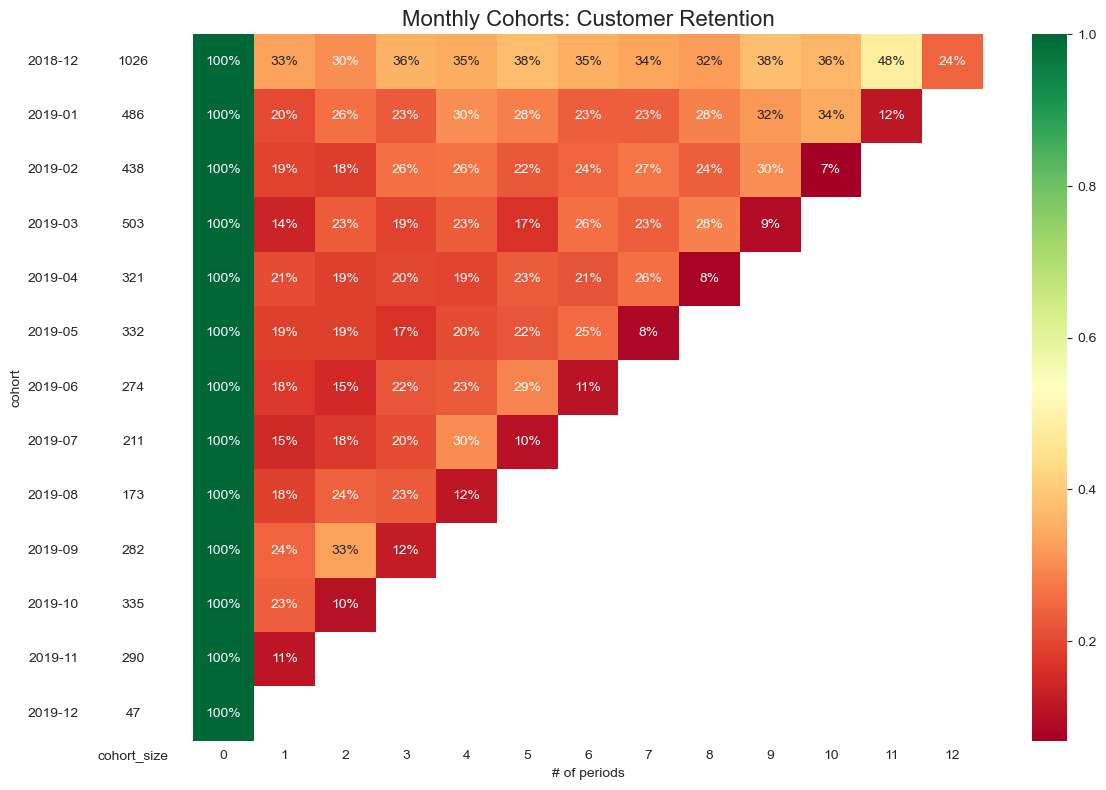

In [22]:
# Create variables order_month and cohort
# The first variable shows the monthly cohort based on the first purchase date
df_sales['order_month'] = df_sales['Date'].dt.to_period('M')

# The second variable is the month calculated from the date of purchase.
df_sales['cohort'] = df_sales.groupby('CustomerNo')['Date'] \
                             .transform('min') \
                             .dt.to_period('M')

# Group by cohort and order_month to count unique customers
df_cohort = df_sales.groupby(['cohort', 'order_month']) \
                    .agg(n_customers=('CustomerNo', 'nunique')) \
                    .reset_index(drop=False)

# Calculate the number of periods along with the number of unique customers in each period
# Combine data per group and order_month and calculate the number of unique customers in each group.
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

# Create a pivot table for cohort analysis
cohort_pivot = df_cohort.pivot_table(index='cohort',
                                     columns='period_number',
                                     values='n_customers')

# Calculate customer retention per cohort period
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# Rotate the y-axis labels for cohort months, rotated to horizontal
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Visualization of customer retention calculation results into a heatmap
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])

    ax[1].set_title('Monthly Cohorts: Customer Retention', fontsize=16)
    ax[1].set(xlabel='# of periods', ylabel='')
    ax[1].tick_params(axis='y', rotation=0)  # Rotate y-axis labels to horizontal

    # Cohort size heatmap
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    ax[0].tick_params(axis='y', rotation=0)  # Rotate y-axis labels to horizontal

    fig.tight_layout()
    plt.show()

## Cohort Analysis for Januari 2019 - November 2019

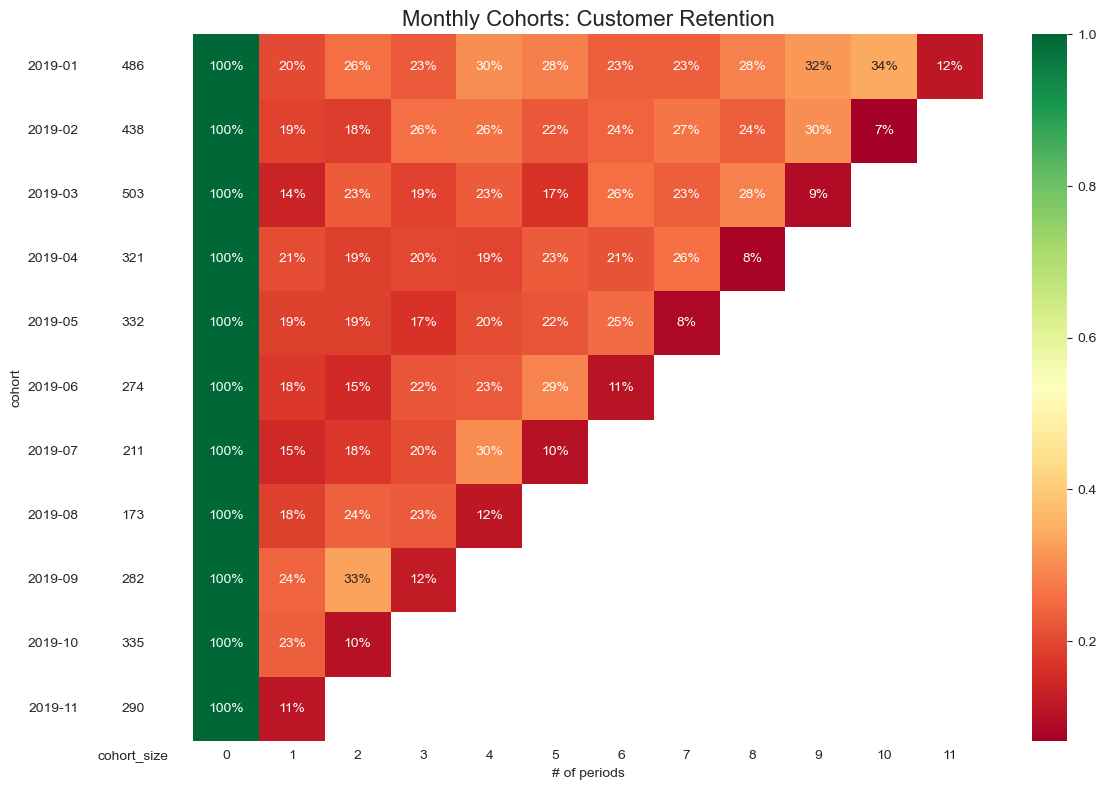

In [24]:
# Create order_month and cohort variables.
df_sales['order_month'] = df_sales['Date'].dt.to_period('M')
df_sales['cohort'] = df_sales.groupby('CustomerNo')['Date'].transform('min').dt.to_period('M')

# Filter data only for cohort months 2019-01 to 2019-11
df_sales_filtered = df_sales[(df_sales['cohort'] >= '2019-01') & (df_sales['cohort'] <= '2019-11')]

# Group by cohort and order_month to count the number of unique customers
df_cohort = df_sales_filtered.groupby(['cohort', 'order_month']) \
                             .agg(n_customers=('CustomerNo', 'nunique')) \
                             .reset_index(drop=False)

# Calculate the number of periods along with the number of unique customers in each period.
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

# Membuat pivot table untuk cohort analysisnya
cohort_pivot = df_cohort.pivot_table(index='cohort',
                                     columns='period_number',
                                     values='n_customers')

# Calculate customer retention per cohort period
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# Visualization of customer retention calculation results into a heatmap
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Customer retention heatmap visualization
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])

    ax[1].set_title('Monthly Cohorts: Customer Retention', fontsize=16)
    ax[1].set(xlabel='# of periods', ylabel='')
    ax[1].tick_params(axis='y', rotation=0)  # Rotate y-axis labels to horizontal

    # Cohort size heatmap visualization
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    ax[0].tick_params(axis='y', rotation=0)  # Rotate y-axis labels to horizontal

    fig.tight_layout()
    plt.show()

## Questions  

1. **What are the characteristics of new customer growth? Is the growth continuing to increase or slowing down?**  

   **Answer:** New customer growth has been gradually slowing down since 2019, with the lowest number of new customers recorded in July and August.  

2. **Each month, the marketing team implements different promotional campaign methods. Which month had the highest retention rate?**  

   **Answer:** In 2019, the promotional campaign method that resulted in the highest retention rate was in **November 2019**.  

### **Conclusion:**  
- In terms of retention rates, the **November 2019 promotional campaign strategy** was the most effective in encouraging previous customers to make repeat purchases.  
- The promotional campaign strategy implemented in **November 2019 successfully increased customer retention rates to approximately 30%**, which is a significant improvement compared to the previous months, where the retention rate was around 20%.  
- **The promotional campaign methods used in July and August should be avoided**, as these two months had the lowest number of new customers and the lowest retention rates, particularly the **August 2019 campaign**, which performed the worst in terms of customer retention.

# Time Series Analysis

Time series analysis adalah analisis untuk melihat trend suatu fenomena berdasarkan waktu.

Time series analysis is a method used to examine trends in a phenomenon over time.

## Questions
Question 1:  
Aggregate the daily sales for each product.  
What is the sales trend? Is there an increase, decrease, or is it stagnant?  

Question 2:  
Conduct a seasonality analysis by observing the total number of orders per day from Monday to Sunday.

In [27]:
# Group data by day and calculate total order value
daily_sales = df_sales.groupby('Date').agg(total_sales=('total_revenue', 'sum')).reset_index()
daily_sales

,Date,total_sales
0,2018-12-01,326820.08
1,2018-12-02,367316.62
2,2018-12-03,206313.62
3,2018-12-05,197565.27
4,2018-12-06,273420.10
...,...,...
300,2019-12-05,289050.50
301,2019-12-06,197440.51
302,2019-12-07,264266.66
303,2019-12-08,223265.49


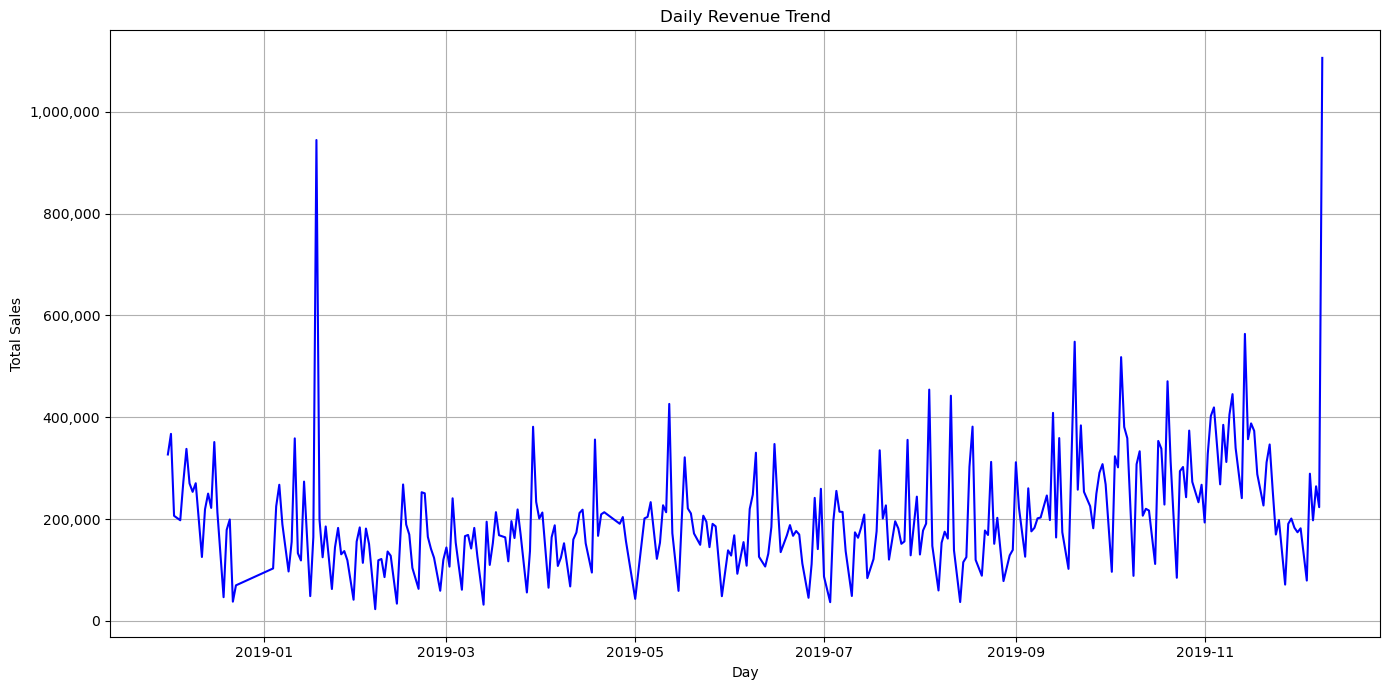

In [28]:
# Visualization of daily_sales table
import matplotlib.ticker as mticker # library to change the y-axis format from 1e6 to hundreds of thousands or millions

plt.figure(figsize=(14, 7))
plt.plot(daily_sales['Date'], daily_sales['total_sales'], linestyle='-', color='b')
plt.title('Daily Revenue Trend')
plt.xlabel('Day')
plt.ylabel('Total Sales')
plt.grid()
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}')) # change the y-axis format from 1e6 to hundreds of thousands or millions
plt.tight_layout()
plt.show()

### Because the daily sales visualization above shows that the fluctuations are too sharp, it is difficult to determine the trend from time series analysis.

### So to make it easier to see the trend of time series analysis, 2 methods will be used:  
- Using smoothing data with a rolling average to reduce noise in the line chart and at the same time making it a trend line to make it easier to read the visualization of the line chart from time series analysis  
- Calculating the trend line using linear regression which will show the average change in total income per day through the slope (line slope)  
    - If the slope> 0, the trend is increasing.
    - If the slope <0, the trend is decreasing.
    - If the slope ≈ 0, the trend is stagnant.

In [31]:
daily_revenue = df_sales.groupby('Date')['total_revenue'].sum()
daily_revenue

Date
2018-12-01     326820.08
2018-12-02     367316.62
2018-12-03     206313.62
2018-12-05     197565.27
2018-12-06     273420.10
                 ...    
2019-12-05     289050.50
2019-12-06     197440.51
2019-12-07     264266.66
2019-12-08     223265.49
2019-12-09    1106069.97
Name: total_revenue, Length: 305, dtype: float64

### 1. Rolling Average, also called Moving Average
Is a technique often used in time series analysis to smooth data fluctuations and identify long-term trends. The method is to calculate the average per window/time window that has been determined. Example: the average sales are calculated per day, the window is changed to per 7 days, the average is calculated.

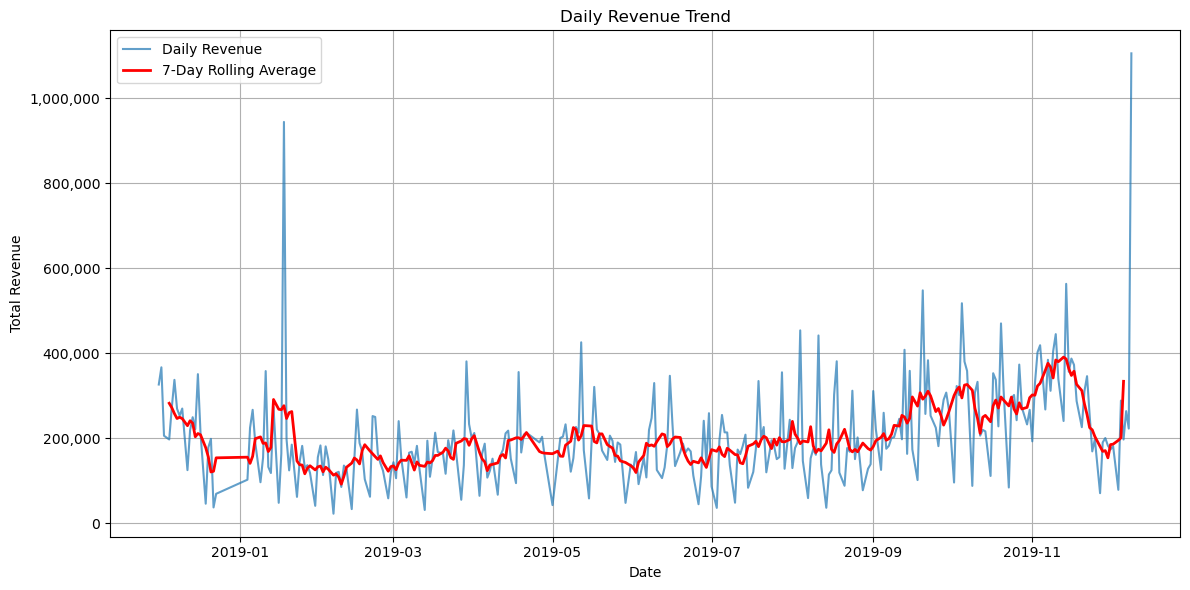

In [33]:
# Perform a rolling average to get a smoother line chart with less noise so that the information from the visualization is easier to read
import matplotlib.ticker as mticker # library to change the y-axis format from 1e6 to hundreds of thousands or millions

# Perform a rolling average to smooth the trend (optional for better visualization)
daily_revenue_smoothed = daily_revenue.rolling(window=7, center=True).mean()
# daily_revenue_smoothed calculates the average revenue for 7 days on the date of the sale
# The function shows a more stable graph than using daily data. Can be seen from the '7-Day Rolling Average' line
# Example: sales occurred from 1 to 7 December. Then the average revenue on 4 December is calculated from the total of the last 3 days & the next 3 days

# Create a daily revenue trend plot
plt.figure(figsize=(12, 6))
plt.plot(daily_revenue.index, daily_revenue, label='Daily Revenue', alpha=0.7)
plt.plot(daily_revenue_smoothed.index, daily_revenue_smoothed, label='7-Day Rolling Average', color='red', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.title('Daily Revenue Trend')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}')) # change the y-axis format from 1e6 to hundreds of thousands or millions
plt.tight_layout()
plt.show()

### Conclusion from trend line rolling average:
- There is an increase of average sales trend in December 2019 when compared to the average sales trend at the beginning of December 2018
- There is a decrease in the average sales around the end of January 2019 to near the beginning of February 2019
- Starting from February 2019 to the end of September 2019, the sales trend is stable and includes the months where the lowest sales point occurs
- The average sales trend starts to increase again in October 2019 to December 2019
- Judging from the sales trend in December 2018 and the increase in the sales trend from October 2019 to December 2019, there is an indication of an increase due to the approaching end-of-year holidays

### 2. Next, determine the sales trend through linear regression
Linear Regression will show the average change in total revenue each day which will be shown through the Slope (line slope). The slope of this line will be measured whether it is increasing (positive slope result), decreasing (negative slope result) or stagnant (slope result = 0).

In [36]:
# Import linregress from scipy.stats library
from scipy.stats import linregress
# This function is used to calculate linear regression, which gives a linear relationship between two variables (number of sales days and daily_revenue). 

# Convert dates to numeric sequences because linear regression requires numeric variables.
time_numeric = range(len(daily_revenue))
# len(daily_revenue): Calculates the total number of days in the daily_revenue data
# range(len(daily_revenue)): Creates a sequence of numbers from 0 to the number of days (e.g., 0, 1, 2, ..., n)

# Perform linear regression between time variable (time_numeric) and daily total revenue (daily_revenue)
slope, intercept, r_value, p_value, std_err = linregress(time_numeric, daily_revenue)
# slope: The slope of the regression line. This value indicates the rate of change in average daily income
# intercept: The value of the point where the regression line intersects the y-axis (daily income at time = 0)
# r_value: The correlation coefficient (r), indicating the strength of the linear relationship between time and income
# p_value: The probability value for testing the significance of the relationship. Low values (< 0.05) indicate a significant relationship
# std_err: The standard error of the slope of the line (how certain the slope estimate is)

# Interpretasi hasil
trend = "increasing" if slope > 0 else "decreasing" if slope < 0 else "stagnant"

print(f"Trend: {trend}")
print(f"Slope: {slope}")

Trend: increasing
Slope: 418.2913716988953


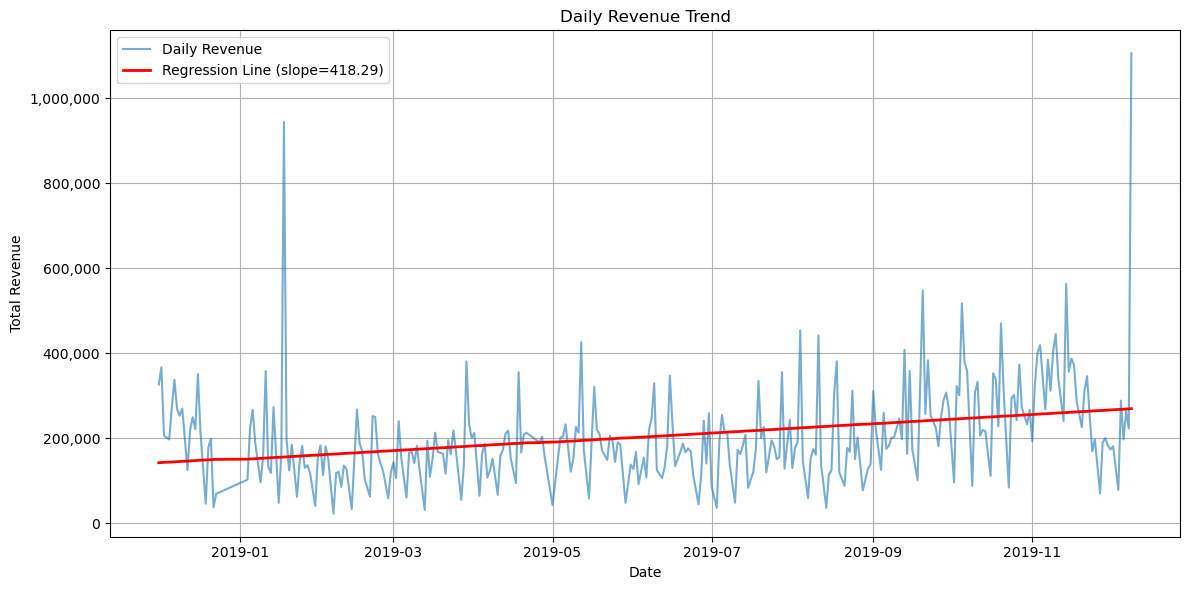

Trend: increasing
Slope: 418.2913716988953


In [37]:
# Visualization for linear regression to explain trend slope

# Calculating the regression line
regression_line = [slope * x + intercept for x in time_numeric]

# Plot the daily revenue and the regression line
plt.figure(figsize=(12, 6))
plt.plot(daily_revenue.index, daily_revenue, label='Daily Revenue', alpha=0.6)
plt.plot(daily_revenue.index, regression_line, label=f'Regression Line (slope={slope:.2f})', color='red', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.title('Daily Revenue Trend')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

print(f"Trend: {trend}")
print(f"Slope: {slope}")

### Conclusion Linear Regression:
Daily revenue experienced an increasing trend with a slope of 418.29 per day or in another word, revenue increased by 418.29 per day

### Seasonality analysis to calculate total transactions on Monday - Sunday

In [40]:
# Extract day from date (0 = Monday, 6 = Sunday)
df_sales['DayOfWeek'] = df_sales['Date'].dt.dayofweek

# Mapping the extracted results with the day name
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df_sales['DayName'] = df_sales['DayOfWeek'].map(day_mapping)

# Count total orders per day
total_orders_per_day = df_sales.groupby('DayName')['TransactionNo'].nunique()
total_orders_per_day

DayName
Friday       3516
Monday       3112
Saturday     3667
Sunday       4212
Thursday     3080
Wednesday    2203
Name: TransactionNo, dtype: int64

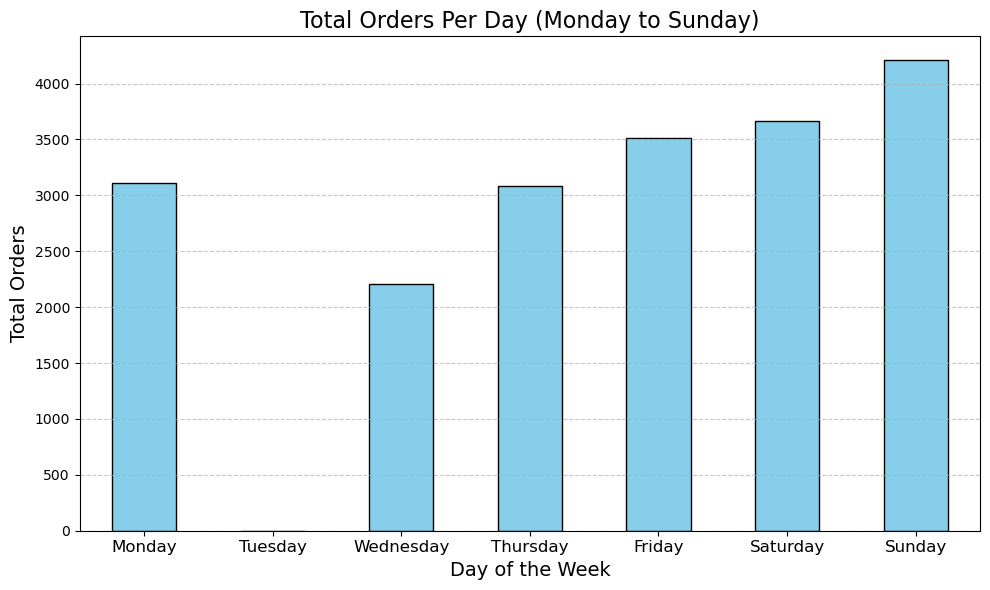

Total orders per day of the week:
DayName
Monday       3112.0
Tuesday         NaN
Wednesday    2203.0
Thursday     3080.0
Friday       3516.0
Saturday     3667.0
Sunday       4212.0
Name: TransactionNo, dtype: float64


In [41]:
# To sort days from Monday to Sunday
total_orders_per_day = total_orders_per_day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Visualization
plt.figure(figsize=(10, 6))
total_orders_per_day.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Total Orders Per Day (Monday to Sunday)', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Total Orders', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print results
print("Total orders per day of the week:")
print(total_orders_per_day)

### From the Total Orders Per Day (Monday to Sunday) chart, we can take insights:
- Customer's transaction behavior -> the closer it gets to the weekend, the number of transactions increases and peaks on Sunday
- There is an anomaly in the data used for analysis, namely that there is no transaction data that occurs on Tuesday

To check the anomaly above, I tried filtering df_sales to retrieve rows of data whose DayOfWeek is Tuesday/Tuesday. The result is correct, there are no transactions on Tuesday.

In [43]:
# Checking whether there are really no transactions on Tuesday
tuesday_transactions = df_sales[df_sales['DayOfWeek'] == 'Tuesday'] # Filter transactions that occurred on Tuesday

tuesday_transactions.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,total_revenue,order_month,cohort,DayOfWeek,DayName


# Price Elasticity

Price elasticity refers to changes in customer demand in response to increases or decreases in a product's price.  

In this section, I will analyze a product whose sales are highly influenced by price fluctuations.  

## Questions 

**Question 1:**  
Which product experiences the most frequent price changes?  

Action: Calculate the number of unique prices for each product and identify products that have been sold with at least **10 different price variations**.  

Price elasticity can be better analyzed when more price variations are observed.  

**Question 2:**  
From the products identified in **Step 1**, calculate the **correlation between price and quantity** for each item.  

Which item has the **strongest negative correlation**?  

**Question 3:**  
Create a **scatter plot** showing the relationship between price and quantity for the item identified in the previous question.  

If the product's price increases, what do you predict will happen to its sales?

### (Price Elasticity) Question 1:
Which product experiences the most frequent price changes?
Count the number of unique prices for each product and take a list of products that have been sold with at least 10 different price variations.

Price Elasticity will be better analyzed when more price variations appear.

In [46]:
# Step 1: Calculate the products that change the most prices
# How to calculate the unique Price for each ProductName
price_changes = df_sales.groupby('ProductName').agg(Unique_Prices=('Price', 'nunique'))

# Find the product that changed the most in price by sort_values descending and take the top product / the one that changed the most in price 
most_frequent_price_change = price_changes.sort_values('Unique_Prices', ascending=False).head(1)

# Step 2: Identify which products have changed price 10 times or more.
products_with_10_price_variations = price_changes[price_changes['Unique_Prices'] >= 10]

In [47]:
most_frequent_price_change

,Unique_Prices
ProductName,
Chilli Lights,23


In [48]:
# Filter to get the 10 products that change prices most frequently
top_10_most_frequent_price_change = price_changes.sort_values('Unique_Prices', ascending=False).head(10)
top_10_most_frequent_price_change

,Unique_Prices
ProductName,
Chilli Lights,23
Hot Water Bottle Tea And Sympathy,20
Cook With Wine Metal Sign,20
Doormat Red Retrospot,19
Fawn Blue Hot Water Bottle,19
Gin And Tonic Diet Metal Sign,19
Pack Of 12 London Tissues,19
Party Bunting,19
Scottie Dog Hot Water Bottle,19


In [49]:
total_unique_products = df_sales['ProductName'].nunique()
total_unique_products

3753

In [50]:
products_with_10_price_variations['Unique_Prices'].value_counts()

Unique_Prices
10    231
11    186
12    105
14     52
13     50
15     24
16     22
17     12
18      8
19      7
20      2
23      1
Name: count, dtype: int64

### Answer to question 1:
- The product that experiences the most frequent price changes is Chilli Lights, which has changed its price 23 times
- There are 700 products that have changed their price 10 times or more

### (Price Elasticity) Question 2:
From all the products taken from step 1, calculate the correlation between price and quantity for each item.  
Which item has the most negative correlation?

In [53]:
# Filter df_sales to only include products with at least 10 price variations
filtered_df_sales = df_sales[df_sales['ProductName'].isin(products_with_10_price_variations.index)]

# Empty dictionary to store correlations
correlations = {}

# Loop through each product in the list products_with_10_price_variations
for product in products_with_10_price_variations.index:
    # Filter data for specific products
    # Filter data so that the product_data variable will contain sales data for products in filtered_df_sales
    product_data = filtered_df_sales[filtered_df_sales['ProductName'] == product] 
    
    # Make sure there is more than one transaction so that correlation can be calculated.
    if product_data.shape[0] > 1:
        # Calculate the correlation between Price and Quantity
        corr = product_data['Price'].corr(product_data['Quantity'])
        # Save the results into the correlation dictionary
        correlations[product] = corr

# Make sure the correlations dictionary is not empty
if correlations:
    # Find products with the highest negative correlation
    most_negative_corr_product = min(correlations, key=correlations.get)
    result = (most_negative_corr_product, correlations[most_negative_corr_product])
else:
    result = "There is no quantifiable correlation."

result

('Set Of 2 Tea Towels Ping Microwave', -0.47773782743109444)

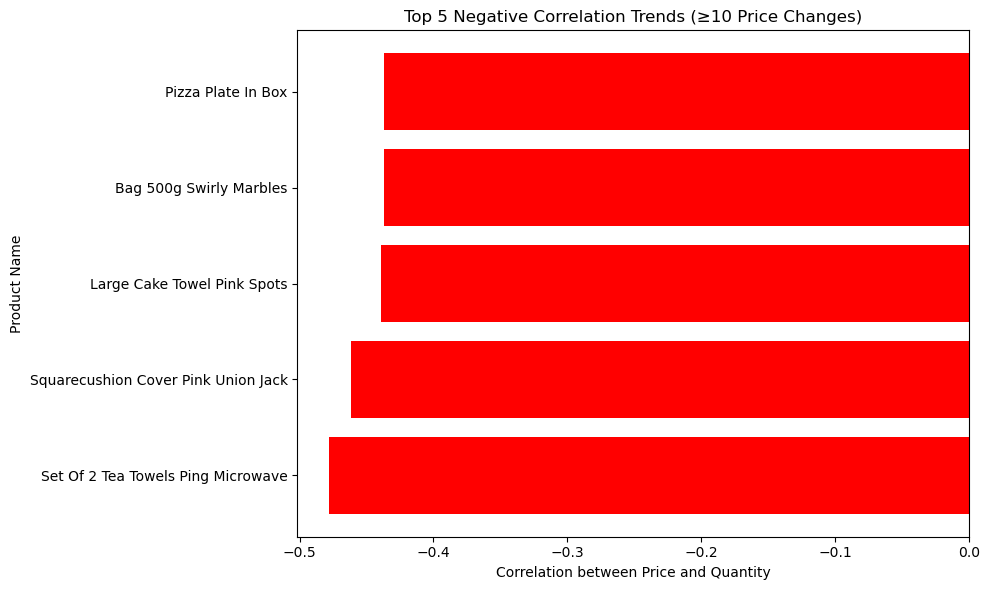

In [54]:
# Filter products with negative correlations
negative_correlations = {product: corr for product, corr in correlations.items() if corr < 0}

# Sort negative correlations from the most negative
sorted_negative_correlations = dict(sorted(negative_correlations.items(), key=lambda item: item[1]))

# Filter top 5 products with negative correlation
top_5_negative_correlations = dict(list(sorted_negative_correlations.items())[:5])

# Plot for top 10 products with negative correlation
plt.figure(figsize=(10, 6))
plt.barh(list(top_5_negative_correlations.keys()), list(top_5_negative_correlations.values()), color='red')
plt.xlabel('Correlation between Price and Quantity')
plt.ylabel('Product Name')
plt.title('Top 5 Negative Correlation Trends (≥10 Price Changes)')
plt.tight_layout()
plt.show()

In [55]:
# Calculate how many customers have negative correlation
count_negative_correlations = len(sorted_negative_correlations) 
count_negative_correlations

552

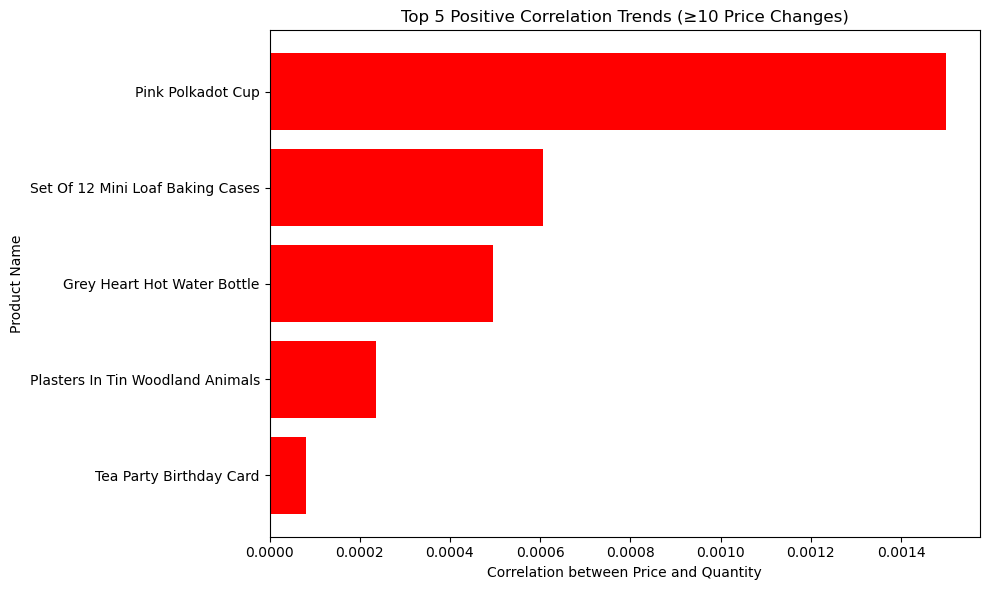

In [56]:
# Filter products with positive correlations
positive_correlations = {product: corr for product, corr in correlations.items() if corr > 0}

# Sort negative correlations from the largest to the most positive value
sorted_positive_correlations = dict(sorted(positive_correlations.items(), key=lambda item: item[1]))

# Filter top 5 products with positive correlation
top_5_positive_correlations = dict(list(sorted_positive_correlations.items())[:5])

# Plot for top 10 products with negative correlation
plt.figure(figsize=(10, 6))
plt.barh(list(top_5_positive_correlations.keys()), list(top_5_positive_correlations.values()), color='red')
plt.xlabel('Correlation between Price and Quantity')
plt.ylabel('Product Name')
plt.title('Top 5 Positive Correlation Trends (≥10 Price Changes)')
plt.tight_layout()
plt.show()

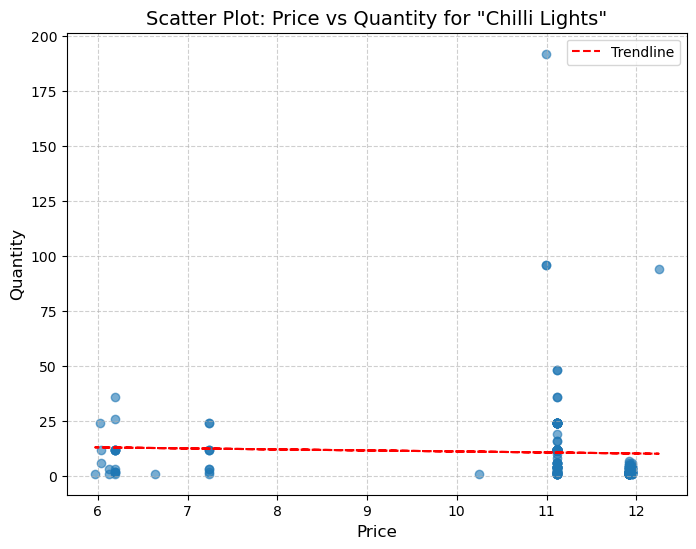

In [57]:
# Filter Chilli Lights products to see Price vs Qty correlation for products that change prices most frequently
top_1_most_frequent_price_change = filtered_df_sales[filtered_df_sales['ProductName'] == 'Chilli Lights']

# Scatter plot for Chilli Lights product
plt.figure(figsize=(8, 6))
plt.scatter(product_data['Price'], product_data['Quantity'], alpha=0.6)

# Add trendline
z = np.polyfit(product_data['Price'], product_data['Quantity'], 1)
p = np.poly1d(z)
plt.plot(product_data['Price'], p(product_data['Price']), "r--", label="Trendline")
plt.legend()

plt.title(f'Scatter Plot: Price vs Quantity for "Chilli Lights"', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [58]:
# Calculate how many customers have positive correlation
count_positive_correlations = len(sorted_positive_correlations) 
count_positive_correlations

148

In [59]:
# Mengubah data series correlations menjadi dataframe
df_correlations = pd.DataFrame([correlations]) 
df_correlations = df_correlations.T 
df_correlations.reset_index(inplace=True)
df_correlations.columns = ['ProductName', 'price_quantity_correlation']
df_correlations

,ProductName,price_quantity_correlation
0,12 Message Cards With Envelopes,-0.080832
1,12 Pencil Small Tube Woodland,-0.040362
2,12 Pencils Small Tube Red Retrospot,0.008916
3,15cm Christmas Glass Ball 20 Lights,-0.191617
4,20 Dolly Pegs Retrospot,-0.015136
...,...,...
695,World War 2 Gliders Asstd Designs,0.023541
696,Zinc Folkart Sleigh Bells,-0.123422
697,Zinc Heart Lattice T-Light Holder,-0.132540
698,Zinc Metal Heart Decoration,0.038028


### Answer to question 2:
'Set Of 2 Tea Towels Ping Microwave' has the most negative correlation of -0.47773782743109444. This means that for the product 'Set Of 2 Tea Towels Ping Microwave' there is a negative relationship between price and sales quantity in other words, product sales are sensitive to price changes.

### Question 3:
Make a scatter plot between price and quantity for the item from the previous question.  
If the product experiences a price increase, what do you think will happen to sales?

Answer: If the product Set Of 2 Tea Towels Ping Microwave experiences a price increase, then the quantity of sales will decrease. It can be seen from the number of sales that are getting smaller Quantity when the scatter plot point is further to the right or in other words the price is getting more expensive. It can also be seen from the trend line which shows that the further to the right or the more expensive the price, the lower the position of the trend line which means the less Quantity of sales.

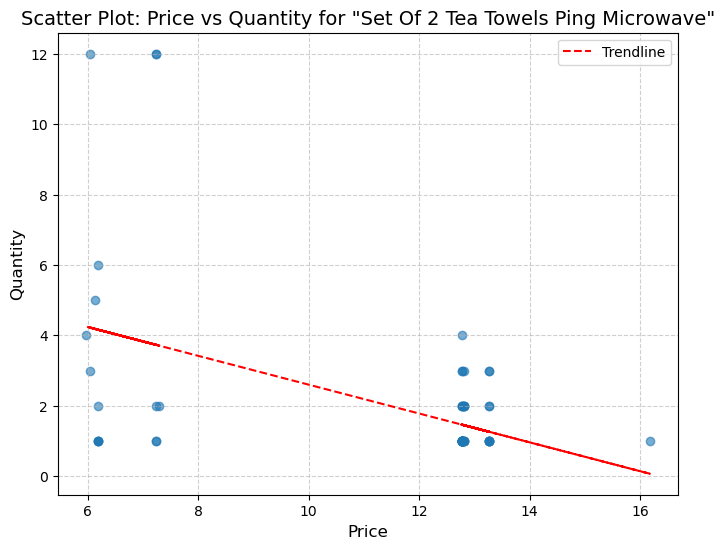

In [62]:
# Filter df_sales data to show products that have the highest negative correlation between Price and Qty according to the variable most_negative_corr_product
product_data = filtered_df_sales[filtered_df_sales['ProductName'] == most_negative_corr_product]

# Scatter plot between Price and Quantity
plt.figure(figsize=(8, 6))
plt.scatter(product_data['Price'], product_data['Quantity'], alpha=0.6)

# Add trendline
z = np.polyfit(product_data['Price'], product_data['Quantity'], 1)
p = np.poly1d(z)
plt.plot(product_data['Price'], p(product_data['Price']), "r--", label="Trendline")
plt.legend()

plt.title(f'Scatter Plot: Price vs Quantity for "{most_negative_corr_product}"', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### **Basket Size Analysis**  

When an e-commerce customer clicks **"add to cart,"** the selected item is stored in a **basket**.  
Upon checkout, all items in the basket are processed and shipped.  

The size of a basket can be measured using **Gross Merchandise Volume (GMV),** which represents the total value of purchased items.  

**Example:**  
On **January 1, 2012:**  
- **Mr. A** buys **1 shampoo for 15,000 IDR** and **2 soaps for 20,000 IDR each.**  
  - **Mr. A's basket size = 55,000 IDR.**  
- **Mrs. B** buys **1 snack for 20,000 IDR.**  
  - **Mrs. B's basket size = 20,000 IDR.**  

Thus, the **total GMV** of the e-commerce platform on **January 1, 2012**, is **75,000 IDR**, with an **average basket size of 37,500 IDR per basket**.  

## **Questions**  
1. Calculate the **average basket size per day** across all transactions. Is it consistent, or are there fluctuations?  
2. Is there a difference in **basket sizes across different countries**?

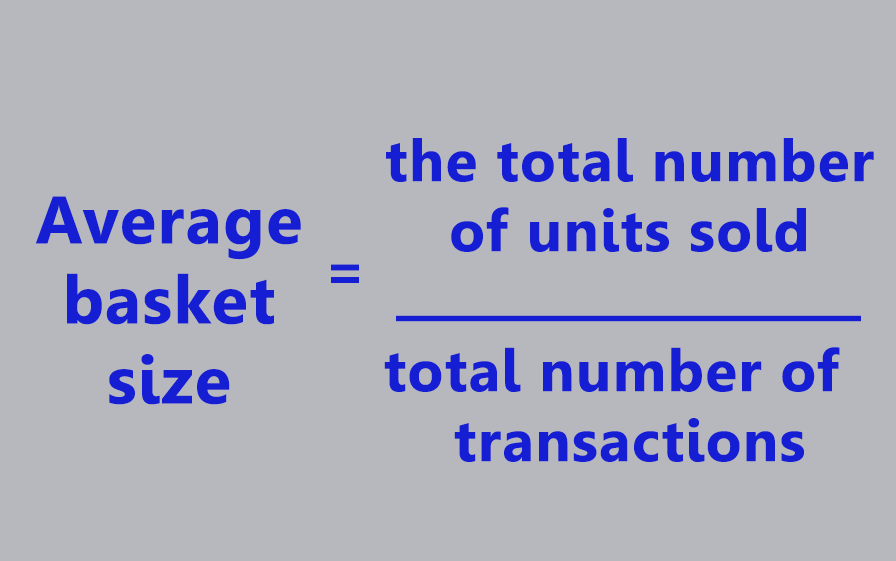

### (Basket Size Analysis) Question 1: Calculate the average basket size of all transactions per day, is it consistent or is there a change?
Answer:
There is a change but not too significant. It can be seen from the slope of the trend slope is only 0.21.

In [65]:
# According to the Average Basket Size formula, it is necessary to first find the daily total number of units sold & total number of transactions

# Step 1: calculate the quantity of sales per day
quantity_per_day = df_sales.groupby('Date').agg(daily_quantity=('Quantity', 'sum'))

# Step 2: calculate the number of transactions that occur each day based on the number of unique transactions per day.
trx_per_day = df_sales.groupby('Date').agg(daily_trx_number=('TransactionNo', 'nunique'))

# Step 3: divide the total number of units sold by the total number of transactions
abs_per_day = quantity_per_day['daily_quantity'] / trx_per_day['daily_trx_number']

In [66]:
# Convert dates to numeric sequences because linear regression requires numeric variables
time_numeric = range(len(abs_per_day))

slope, intercept, r_value, p_value, std_err = linregress(time_numeric, abs_per_day)

# Results interpretasi
trend = "increasing" if slope > 0 else "decreasing" if slope < 0 else "stagnant"

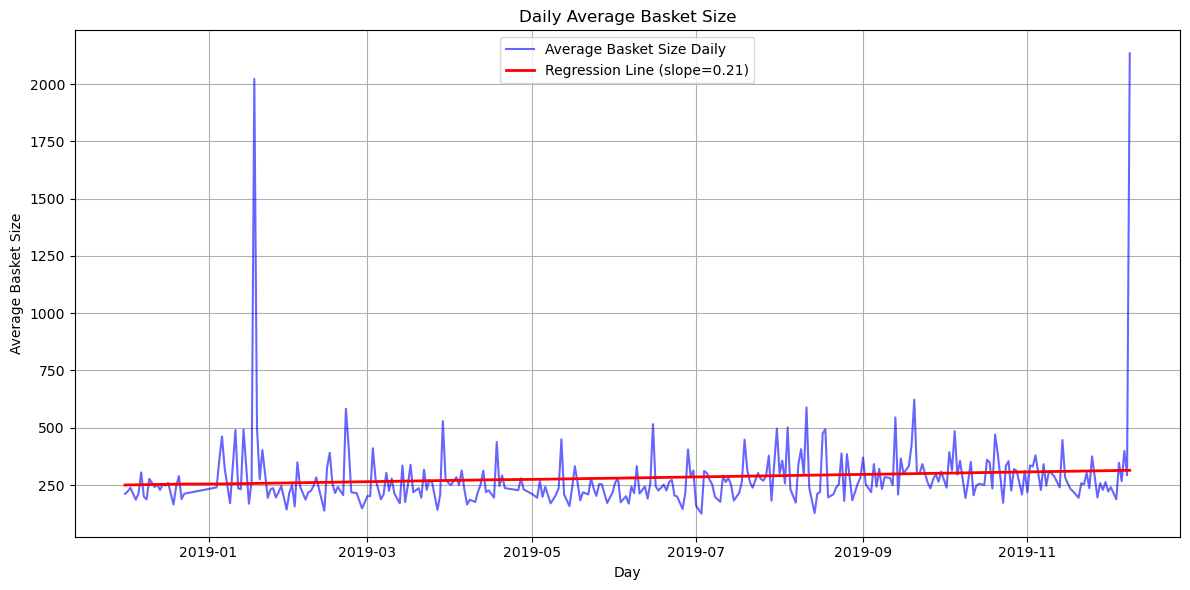

Trend: increasing
Slope: 0.2105827411559216


In [67]:
# Visualization with linear regression to explain the Average Basket Size trend

# Calculating the regression line
regression_line = [slope * x + intercept for x in time_numeric]

plt.figure(figsize=(12, 6))
plt.plot(abs_per_day.index, abs_per_day, label='Average Basket Size Daily', alpha=0.6, color='b')
plt.plot(abs_per_day.index, regression_line, label=f'Regression Line (slope={slope:.2f})', color='red', linewidth=2)
plt.title('Daily Average Basket Size')
plt.xlabel('Day')
plt.ylabel('Average Basket Size')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

print(f"Trend: {trend}")
print(f"Slope: {slope}")

### (Basket Size Analysis) Question 2: Is there a difference in the size of the basketball from different countries?
Answer:
Yes. There is a difference in the size of the basketball in each country with the most striking difference from the ABS of the Netherlands which has the highest value exceeding 2000 average basketball sizes.

In [69]:
# Step 1: find the total units sold from each country
total_unit_sold = df_sales.groupby('Country').agg(units_sold=('Quantity', 'sum'))
total_unit_sold = total_unit_sold.sort_values('units_sold', ascending=False)

# Step 2: find the total number of transactions from each country
total_number_transaction = df_sales.groupby('Country').agg(total_transaction=('TransactionNo', 'count'))
total_number_transaction = total_number_transaction.sort_values('total_transaction', ascending=False)

In [70]:
# Find ABS with the formula total units sold per country / total number of transactions per country
country_average_basket_size = total_unit_sold['units_sold'] / total_number_transaction['total_transaction']

country_average_basket_size = country_average_basket_size.sort_values(ascending=False)

country_average_basket_size

Country
Sweden                  87.860294
Netherlands             86.343078
Japan                   77.308605
Australia               52.577560
Czech Republic          27.916667
Singapore               24.344186
Denmark                 21.004902
Lithuania               18.823529
EIRE                    18.795184
Norway                  18.640777
Canada                  18.413333
Finland                 15.583090
Bahrain                 15.294118
Hong Kong               14.973856
United Arab Emirates    14.641791
Channel Islands         13.529032
Switzerland             13.385150
Israel                  12.773743
Germany                 11.759375
France                  11.411431
USA                     11.389513
Brazil                  11.387097
Greece                  11.328358
Italy                   11.057692
Spain                    9.849120
United Kingdom           9.770141
Poland                   9.473988
Belgium                  9.465497
Portugal                 9.101197
Saudi 

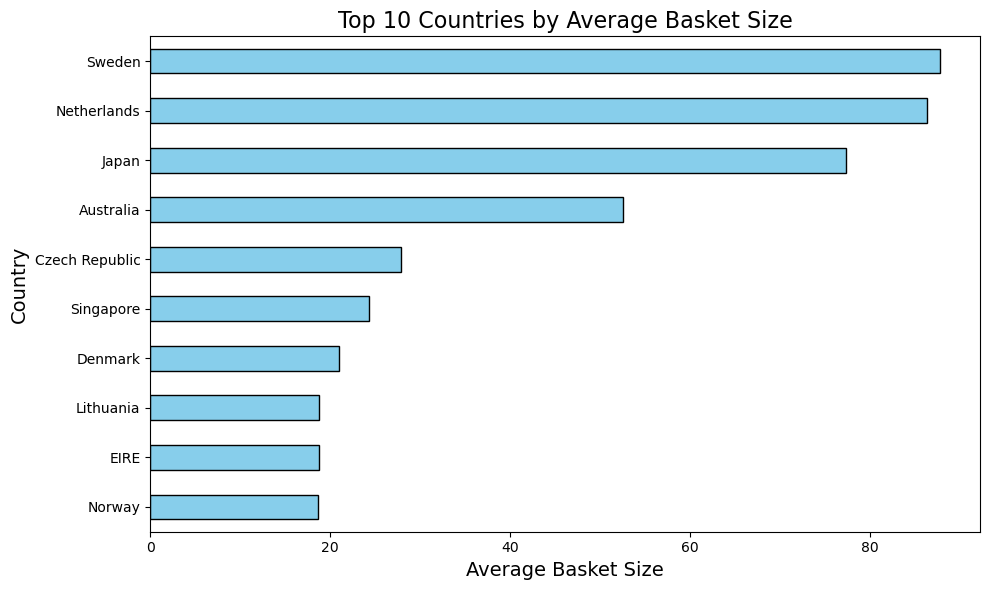

In [71]:
# Visualization: Top 10 Countries by Average Basket Size
top_countries = country_average_basket_size.head(10)
plt.figure(figsize=(10, 6))
top_countries.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 10 Countries by Average Basket Size', fontsize=16)
plt.xlabel('Average Basket Size', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

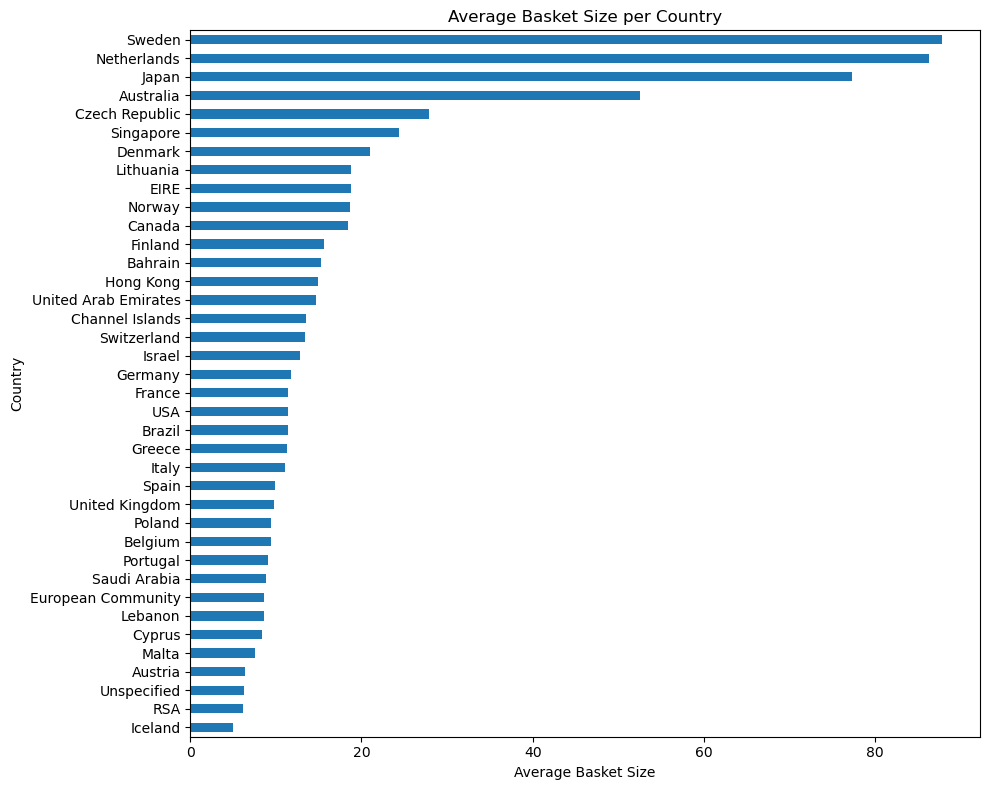

In [72]:
# Visualization
country_average_basket_size.plot(kind='barh', figsize=(10, 8), legend=False)

plt.title('Average Basket Size per Country')
plt.xlabel('Average Basket Size')
plt.ylabel('Country')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [73]:
df_sales.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,total_revenue,order_month,cohort,DayOfWeek,DayName
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,257.64,2019-12,2019-06,0,Monday
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,383.40,2019-12,2018-12,0,Monday
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,138.36,2019-12,2018-12,0,Monday
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,127.80,2019-12,2018-12,0,Monday
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,71.64,2019-12,2018-12,0,Monday


In [74]:
sum_cust = df_sales['CustomerNo'].nunique()
sum_cust

4718

In [75]:
sum_trx = df_sales['TransactionNo'].nunique()
sum_trx

19790

In [76]:
sum_qty = df_sales['Quantity'].sum()
sum_qty

5591498

In [77]:
sum_total_revenue = df_sales['total_revenue'].sum()
sum_total_revenue

62965974.33999998

# Crucial Question

These are the 5 main questions asked by the creator of this sales dataset.  

You can use the analysis done in the previous section, or do a new analysis to answer the questions below.  
1. What are the most profitable segment customers?
2. Based on your findings, what strategy could you recommend to the business to gain more profit?

### (Crucial Question) Question 1: What are the most profitable segment customers?
To answer this question I will use RFM Analysis segmentation. RFM Analysis will categorize the most profitable customers (most recent transaction time, most frequent transactions & high transaction value) as Top Customers. So the answer to profitable segment customers can be seen from revenue generated from each customer category, the result of RFM Analysis.

# RFM Analysis

## Recency Calculation

Find out the last time a customer made a transaction/shopped at our store

In [82]:
# Recency
latest_date = df_sales['Date'].max() # Find out when the customer last shopped (as above)
latest_trx_per_customer = df_sales.sort_values('Date').groupby('CustomerNo').tail(1) # Find out when the customer last shopped

latest_trx_per_customer['days_to_today'] = latest_date - latest_trx_per_customer['Date'] 
latest_trx_per_customer['days_to_today'] 

534517   373 days
533622   373 days
533932   373 days
534015   373 days
533767   373 days
           ...   
908        0 days
1023       0 days
808        0 days
1074       0 days
0          0 days
Name: days_to_today, Length: 4718, dtype: timedelta64[ns]

In [83]:
latest_trx_per_customer.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,total_revenue,order_month,cohort,DayOfWeek,DayName,days_to_today
534517,536534,2018-12-01,22834,Hand Warmer Babushka Design,12.40,12,15350.0,United Kingdom,148.80,2018-12,2018-12,5,Saturday,373 days
533622,536403,2018-12-01,22867,Hand Warmer Bird Design,12.15,96,12791.0,Netherlands,1166.40,2018-12,2018-12,5,Saturday,373 days
533932,536420,2018-12-01,22969,Homemade Jam Scented Candles,11.74,12,16583.0,United Kingdom,140.88,2018-12,2018-12,5,Saturday,373 days
534015,536464,2018-12-01,90200D,Pink Sweetheart Bracelet,14.61,3,17968.0,United Kingdom,43.83,2018-12,2018-12,5,Saturday,373 days
533767,536409,2018-12-01,20717,Strawberry Shopper Bag,11.53,1,17908.0,United Kingdom,11.53,2018-12,2018-12,5,Saturday,373 days


In [84]:
# Change dtype: timedelta64 to integer
latest_trx_per_customer['days_to_today'] = latest_trx_per_customer['days_to_today'].dt.days

<Axes: ylabel='Frequency'>

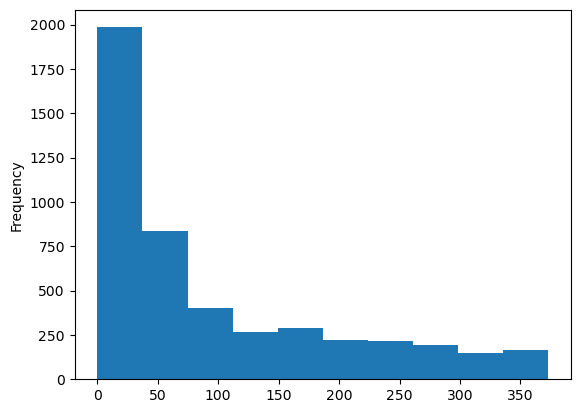

In [85]:
# Create a plot to see the number of times per CustomerNo shopped / the last time a customer shopped
df_recency = latest_trx_per_customer[['CustomerNo','days_to_today']]
df_recency['days_to_today'].plot(kind='hist')

In [86]:
# Determine customers who have recently made transactions, have made transactions for quite a long time, or have not made transactions for a long time
# Determine it with qcut
df_recency['R_score'] = pd.qcut(df_recency['days_to_today'],3,labels=['Recent','Normal','Long'])

# qcut = Quartal Cut = divides our data into several Quartiles (in this case divided by 3)
df_recency

C:\Users\benny\AppData\Local\Temp\ipykernel_16128\2558540919.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recency['R_score'] = pd.qcut(df_recency['days_to_today'],3,labels=['Recent','Normal','Long'])


,CustomerNo,days_to_today,R_score
534517,15350.0,373,Long
533622,12791.0,373,Long
533932,16583.0,373,Long
534015,17968.0,373,Long
533767,17908.0,373,Long
...,...,...,...
908,12423.0,0,Recent
1023,17497.0,0,Recent
808,15492.0,0,Recent
1074,14498.0,0,Recent


In [87]:
# View qcut result data statistically
df_recency.groupby('R_score').agg({'days_to_today':['min','max','mean','median','count']})

C:\Users\benny\AppData\Local\Temp\ipykernel_16128\2889108634.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_recency.groupby('R_score').agg({'days_to_today':['min','max','mean','median','count']})


days_to_today                              
                  min  max        mean median count
R_score                                            
Recent              0   26   11.697891   10.0  1612
Normal             28  100   56.235486   54.0  1533
Long              101  373  221.123967  212.0  1573

## Volume Calculation

Calculate ABS for each customer or budget spent by each customer

<Axes: ylabel='Frequency'>

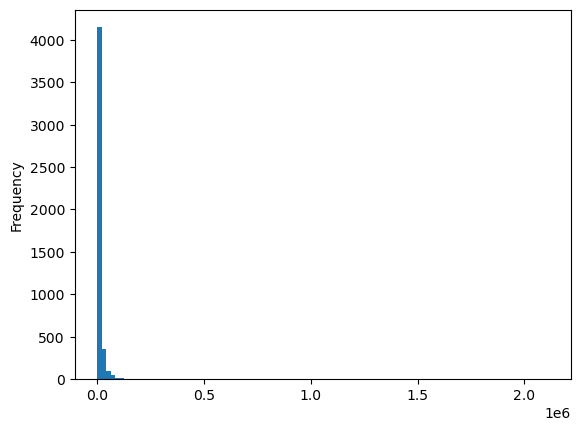

In [89]:
df_volume = df_sales.groupby('CustomerNo').agg({'total_revenue':'sum'}) # Calculate transaction volume per CustomerID
df_volume['total_revenue'].plot(kind='hist',bins=100) # Visualize the calculation of transaction volume per CustomerID in the form of a histplot

In [90]:
# Same as the previous df_frequency step, for df_volume divide customers into 3 quartiles / 3 categories with the labels Low, Medium and High
# The method is also the same using Qcut
df_volume['V_score'] = pd.qcut(df_volume['total_revenue'],3,labels=['Low','Medium','High'])
df_volume

,total_revenue,V_score
CustomerNo,,
12004.0,1509.60,Low
12006.0,24.76,Low
12008.0,5689.57,Medium
12013.0,69.96,Low
12024.0,149.52,Low
...,...,...
18280.0,623.26,Low
18281.0,576.58,Low
18282.0,1044.86,Low


In [91]:
# View qcut result data statistically
df_volume.groupby('V_score').agg({'total_revenue':['min','max','mean','median','count']})

C:\Users\benny\AppData\Local\Temp\ipykernel_16128\59217033.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_volume.groupby('V_score').agg({'total_revenue':['min','max','mean','median','count']})


total_revenue                                          
                  min         max          mean    median count
V_score                                                        
Low              5.97     2584.17   1263.549008   1253.17  1573
Medium        2584.78     8681.02   5078.419472   4828.47  1572
High          8685.27  2112282.03  33690.435054  16972.33  1573

# Frequency Calculation 
See how often customers make transactions

In [93]:
df_sales.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,total_revenue,order_month,cohort,DayOfWeek,DayName
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,257.64,2019-12,2019-06,0,Monday
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,383.40,2019-12,2018-12,0,Monday
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,138.36,2019-12,2018-12,0,Monday
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,127.80,2019-12,2018-12,0,Monday
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,71.64,2019-12,2018-12,0,Monday


<Axes: ylabel='Frequency'>

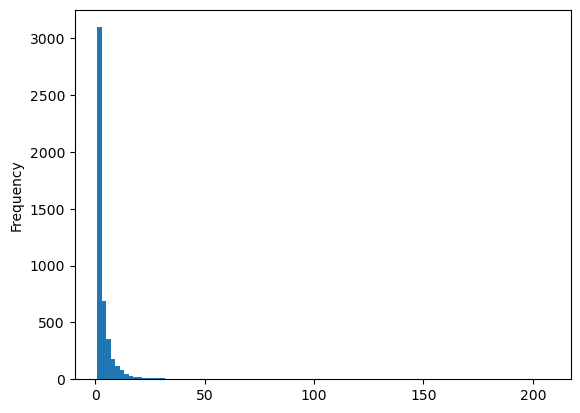

In [94]:
df_frequency = df_sales.groupby('CustomerNo').agg({'TransactionNo':'nunique'}) # Invoice number must be unique per CustomerID
# The objective using nunique because we aim to distinguish between customers who make a single purchase with a high Average Basket Size (ABS)
# and those who shop frequently but have a low ABS.

df_frequency['TransactionNo'].plot(kind='hist',bins=100)

For F_score calculation using pd.qcut causes the following error:   
__ValueError: Bin edges must be unique: Index([1.0, 1.0, 4.0, 207.0], dtype='float64', name='TransactionNo'). You can drop duplicate edges by setting the 'duplicates' kwarg__  

Using pd.qcut to divide TransactionNo data into 3 quantile categories (Low, Medium, High) results in ValueError because most transactions have a TransactionNo value = 1, resulting in pd.qcut being unable to create unique bin edges.

So to overcome this ValueError I will use pd.cut to label F_score manually

In [96]:
df_frequency['F_score'] = pd.cut(df_frequency['TransactionNo'],bins=[0,5,25,np.Inf],labels=['Low','Medium','High'],right=True)

In [97]:
df_frequency['F_score'].value_counts()

F_score
Low       3783
Medium     868
High        67
Name: count, dtype: int64

In [98]:
df_frequency.groupby('F_score').agg({'TransactionNo':['min','max','mean','median','count']})

C:\Users\benny\AppData\Local\Temp\ipykernel_16128\874623131.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_frequency.groupby('F_score').agg({'TransactionNo':['min','max','mean','median','count']})


TransactionNo                             
                  min  max       mean median count
F_score                                           
Low                 1    5   2.165741    2.0  3783
Medium              6   25   9.816820    8.0   868
High               26  207  45.895522   34.0    67

## K-means to determine the number of customer segmentation clusters

In [100]:
recency_rfm = df_recency.set_index('CustomerNo')['days_to_today'] # because the df_recency data has an index, in this script the index is set using CustomerID
volume_rfm = df_volume['total_revenue']
frequency_rfm = df_frequency['TransactionNo']

In [101]:
rfm = pd.concat([recency_rfm,frequency_rfm,volume_rfm],axis=1)

rfm.columns = ["Recency", "Frequency", "Monetary"]

rfm

,Recency,Frequency,Monetary
CustomerNo,,,
15350.0,373,1,641.16
12791.0,373,1,1166.40
16583.0,373,1,1376.86
17968.0,373,1,1899.72
17908.0,373,1,1998.18
...,...,...,...
12423.0,0,9,14766.41
17497.0,0,2,16972.33
15492.0,0,3,18230.28


In [102]:
rfm.isna().sum()

Recency      0
Frequency    0
Monetary     0
dtype: int64

In [103]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
scaled = scaler.fit_transform(rfm)

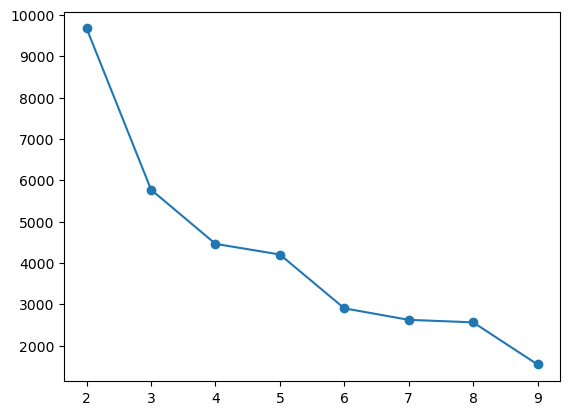

In [104]:
# elbow method to determine the number of clusters
from sklearn.cluster import KMeans

# inertia = []
# for i in np.arange(1,11):
#     kmeans=KMeans(n_clusters=i)
#     kmeans.fit(scaled)
#     inertia.append(kmeans.inertia_)

# plt.plot(range(2,10),inertia)

list_sum_distance = []
for k in range(2,10):
    model = KMeans(n_clusters = k, n_init='auto')
    model.fit(scaled)
    inertia = model.inertia_
    list_sum_distance.append(inertia)

plt.plot(range(2,10),list_sum_distance, marker='o')

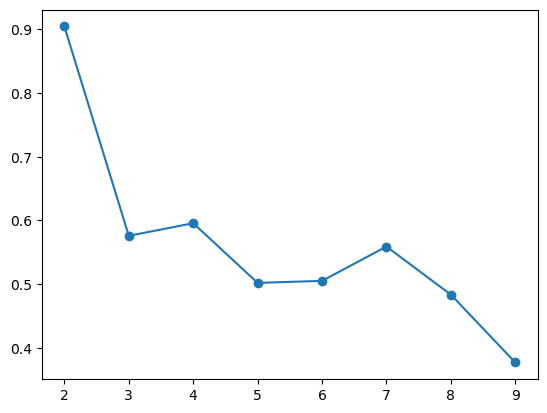

In [105]:
# Silhouette Score to determine the number of clusters
from sklearn.metrics import silhouette_score
list_silhouette = []
for k in range(2,10):
    model = KMeans(n_clusters = k, n_init='auto')
    model.fit(scaled)
    cluster = model.labels_
    score = silhouette_score(scaled,cluster)
    list_silhouette.append(score)


# plt.plot(list_silhouette="o")
plt.plot(range(2,10),list_silhouette, marker="o")

### From the results of the Elbow Method and Silhouette Method, the number of clusters taken was 4.

In [107]:
kmeans=KMeans(n_clusters=4, n_init='auto')
kmeans.fit(scaled)
rfm['Clusters']=(kmeans.labels_ +1)

rfm

,Recency,Frequency,Monetary,Clusters
CustomerNo,,,,
15350.0,373,1,641.16,3
12791.0,373,1,1166.40,3
16583.0,373,1,1376.86,3
17968.0,373,1,1899.72,3
17908.0,373,1,1998.18,3
...,...,...,...,...
12423.0,0,9,14766.41,1
17497.0,0,2,16972.33,1
15492.0,0,3,18230.28,1


In [108]:
# Fixed how to select columns with lists instead of tuples
group_cluster = rfm.groupby(['Clusters'])[['Recency', 'Frequency', 'Monetary']].mean()
group_cluster

,Recency,Frequency,Monetary
Clusters,,,
1,44.126805,3.590709,9267.062335
2,12.201550,19.984496,61351.719612
3,245.792197,1.553344,3836.263121
4,24.611111,69.000000,710774.533333


## Clusters conclusion
- Cluster 1 = Best recency, second best frequency and second best monetary. So it is included in the Potential Top Customers category
- Cluster 2 = Lowest RFM score, likely to be included in the Lost Customers category
- Cluster 2 = Second best recency, best frequency and best monetary. So it is included in the Top Customers category
- Cluster 4 = Second worst RFM score, so it is included in Normal Customers

### In my opinion, there are too few clusters for customer segmentation, therefore I use 7 customer segmentations assessed by the RFM score label (Low, Medium, High)

# Merging the Three Components of RFM Analysis

In [112]:
df_recency.head(2)

,CustomerNo,days_to_today,R_score
534517,15350.0,373,Long
533622,12791.0,373,Long


In [113]:
df_volume.head(2)

,total_revenue,V_score
CustomerNo,,
12004.0,1509.60,Low
12006.0,24.76,Low


In [114]:
df_frequency.head(2)

,TransactionNo,F_score
CustomerNo,,
12004.0,1,Low
12006.0,1,Low


In [115]:
recency = df_recency.set_index('CustomerNo')['R_score'] # because the df_recency data has an index, in this script the index is set using CustomerID
volume = df_volume['V_score']
frequency = df_frequency['F_score']

In [116]:
# The R,V,F score results above are then concated/combined
df_rfm = pd.concat([recency,frequency,volume],axis=1)
# axis=1 means the combined data results will be combined sideways, with CustomerID as the index reference

df_rfm
# The result will show each CustomerID will be categorized into which category based on R_score, F_score and V_score

,R_score,F_score,V_score
CustomerNo,,,
15350.0,Long,Low,Low
12791.0,Long,Low,Low
16583.0,Long,Low,Low
17968.0,Long,Low,Low
17908.0,Long,Low,Low
...,...,...,...
12423.0,Recent,Medium,High
17497.0,Recent,Low,High
15492.0,Recent,Low,High


In [117]:
def categorize_customer(row):
    R = row['R_score']
    F = row['F_score']
    V = row['V_score']

    if R == 'Recent' and F == 'High' and V == 'High':
        return 'Top Customer'
    elif (R == 'Normal' or R == 'Recent') and F == 'High' and (V == 'Medium' or V == 'High'):
        return 'Loyal Customers'
    elif (R == 'Normal' or R == 'Recent') and F == 'Medium' and (V == 'Medium' or V == 'High'):
        return 'Potential Loyalist'
    elif (R == 'Normal' or R == 'Recent') and F == 'Low' and (V == 'Medium' or V == 'Low'):
        return 'New Customers'
    elif (R == 'Normal' or R == 'Recent') and F == 'Low' and (V == 'Medium' or V == 'High'):
        return 'Promising'
    elif R == 'Long' and (F == 'Medium' or F == 'High') and (V == 'Medium' or V == 'High'):
        return 'At-Risk-Customers'
    elif R == 'Long' and (F == 'Medium' or F == 'High') and V == 'High':
        return "Can't Lose Them"
    elif R == 'Long' and F == 'Low' and (V == 'Medium' or V == 'Low'):
        return 'Lost Customers'
    else:
        return 'Promising'


# Apply final categorization for customers to df_rfm
df_rfm['Final_Customer_Category'] = df_rfm.apply(categorize_customer, axis=1)

In [118]:
df_rfm['Final_Customer_Category'].value_counts()

Final_Customer_Category
New Customers         1677
Lost Customers        1358
Potential Loyalist     828
Promising              755
Top Customer            64
At-Risk-Customers       34
Loyal Customers          2
Name: count, dtype: int64

### The answer to Crucial Question number 4 can be answered with the list of top customers below:

In [120]:
top_customers = df_rfm[df_rfm['Final_Customer_Category'] == 'Top Customer']
top_customers.head()

,R_score,F_score,V_score,Final_Customer_Category
CustomerNo,,,,
14849.0,Recent,High,High,Top Customer
16422.0,Recent,High,High,Top Customer
13018.0,Recent,High,High,Top Customer
15005.0,Recent,High,High,Top Customer
16168.0,Recent,High,High,Top Customer


In [121]:
loyal_customers = df_rfm[df_rfm['Final_Customer_Category'] == 'Loyal Customers']
loyal_customers.head()

,R_score,F_score,V_score,Final_Customer_Category
CustomerNo,,,,
16029.0,Normal,High,High,Loyal Customers
17961.0,Recent,High,Medium,Loyal Customers


C:\Users\benny\AppData\Local\Temp\ipykernel_16128\204695397.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_rfm, x='Final_Customer_Category', palette="viridis")


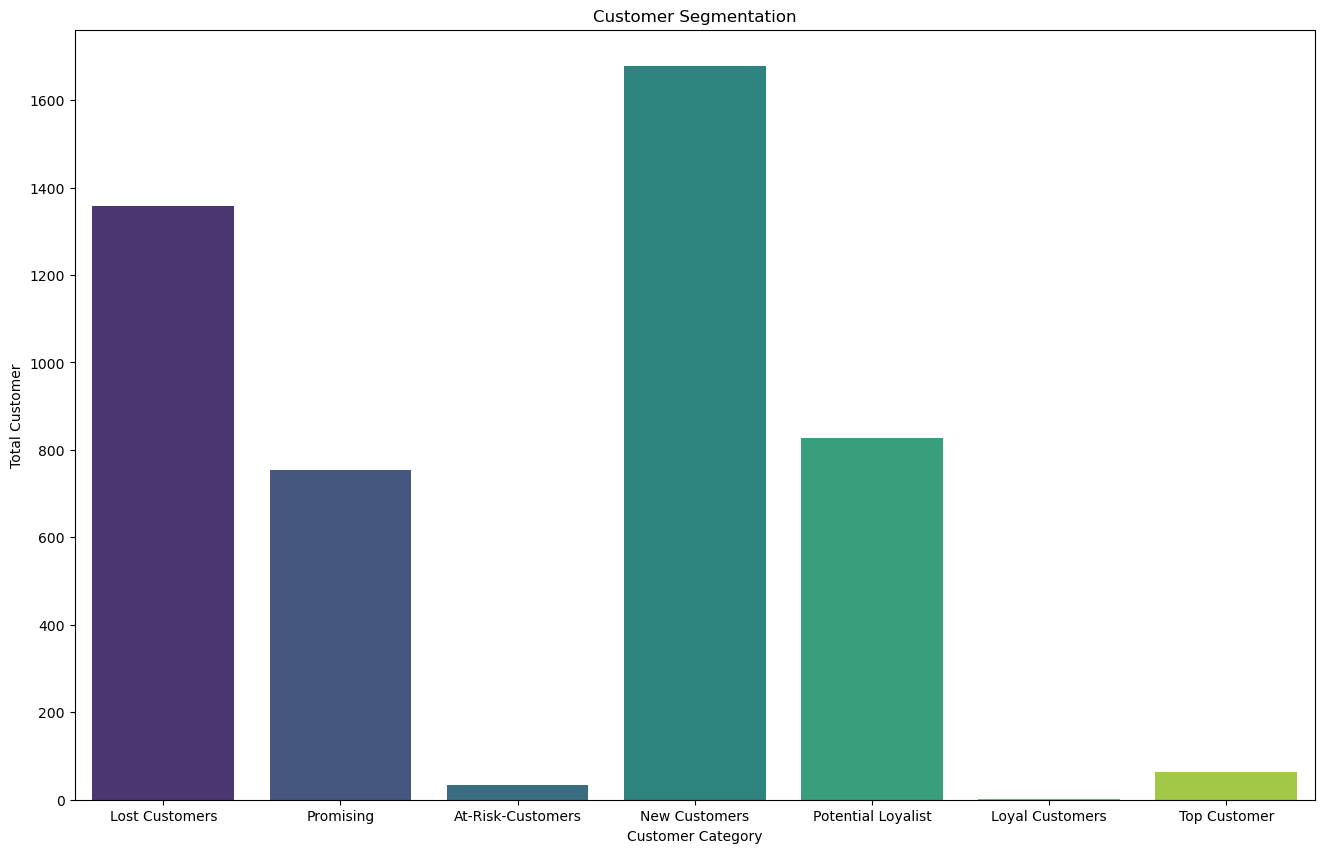

In [122]:
# Visualization
plt.figure(figsize=(16, 10))
sns.countplot(data=df_rfm, x='Final_Customer_Category', palette="viridis")
plt.title("Customer Segmentation")
plt.xlabel("Customer Category")
plt.ylabel("Total Customer")
plt.xticks(rotation=0)
plt.show()

Top Customer: These are your best customers who are highly engaged and spend the most.  
- R_score = Recent
- F_score = High
- V_score = High  


Loyal Customers: Customers who regularly purchase from you and contribute significantly to revenue.  
- R_score = Normal or Recent
- F_score = High
- V_score = Medium or High  


Potential Loyalist: Customers who show potential to become loyal with the right engagement strategies.  
- R_score = Normal or Recent
- F_score = Medium
- V_score = Medium or High  


New Customers: Recently acquired customers who need nurturing to become repeat buyers.  
- R_score = Normal or Recent
- F_score = Low
- V_score = Low or Medium  


Promising: Customers with potential to engage further and increase purchases.  
- R_score = Normal or Recent
- F_score = Low
- V_score = Medium or High  


At-Risk-Customers: Previously engaged customers who may be losing interest.  
- R_score = Long
- F_score = Medium or High
- V_score = Medium or High  

Lost Customers: Customers who are unlikely to return unless targeted with special offers.  
- R_score = Long
- F_score = Low
- V_score = Medium or Low  

# (Crucial Question) Question 2: Based on your findings, what strategy could you recommend to the business to gain more profit?
This crucial question requires a deeper analysis. So I made an additional analysis to answer what strategy needs to be done to gain more profit.

## **Further Analysis Ideas:**  

- **Integrate** `df_rfm` with `df_sales` to combine the results of the **RFM analysis** with **product segmentation** and **price vs. quantity correlation analysis**.  
- After merging, the next analysis can examine **customer category movements** from the **RFM analysis** perspective in terms of **revenue, ABS (Average Basket Size), total sales quantity, number of transactions, and number of customers per category**.  
- Based on the **performance analysis of each customer category**, we can focus on specific customer segments as a reference for executing **promotions** or developing **campaign strategies**.  
- Analyze the **number of transactions per product category** within each customer category to identify the most suitable **product categories** for **promotional activities**.  
- Identify which regions have the highest number of customers per category to define **tailored marketing strategies for each country**.  
- Analyze **price elasticity** or the **price vs. quantity correlation per country** to determine which markets are most sensitive to price increases.  
- **Price elasticity** can also be aggregated by **season** to observe seasonal pricing sensitivity.  
- **Enhance seasonality analysis** by labeling each transaction date with its corresponding season.  
- Utilize the **Prophet model** to forecast **revenue trends for 2020**.

## Merging df_sales, df_rfm datasets and correlation coefficient between price vs quantity

In [127]:
# Select only required columns from df_rfm
df_rfm_subset = df_rfm[['Final_Customer_Category']].reset_index()

# Perform a merge between df_merge and df_rfm_subset based on CustomerNo
df_merge = pd.merge(df_sales, df_rfm_subset, on='CustomerNo', how='left')

### Merge data df_merge dan merged_segmentation yang berisi final_product_category

In [129]:
# Select only required columns from merged_segmentation (ProductName and final_segmentation)
merged_segmentation_subset = merged_segmentation[['ProductName', 'final_product_segmentation']]

# Perform a merge between df_merge and merged_segmentation_subset based on ProductName
df_merge = pd.merge(df_merge, merged_segmentation_subset, on='ProductName', how='left')

In [130]:
# After df sales, df rfm and merged_segmentation being merged, I want to see how many customers per final category and per country
country_segmentation = df_merge.groupby(['Country', 'Final_Customer_Category']).agg(category_counts=('Final_Customer_Category', 'count')).reset_index(drop=False)
country_segmentation

,Country,Final_Customer_Category,category_counts
0,Australia,Lost Customers,10
1,Australia,New Customers,62
2,Australia,Potential Loyalist,1114
3,Australia,Promising,445
4,Austria,Lost Customers,43
...,...,...,...
102,United Kingdom,Potential Loyalist,184238
103,United Kingdom,Promising,115024
104,United Kingdom,Top Customer,46648
105,Unspecified,Lost Customers,328


In [131]:
# Filter only for "Promising" and "Potential Loyalist" categories
promising_potential_customer = country_segmentation[country_segmentation['Final_Customer_Category'].isin(['Promising', 'Potential Loyalist'])]

# View customer data descriptions for the Potential Loyalist and Promising categories
promising_potential_customer.groupby('Final_Customer_Category').agg({'category_counts':['min','max','mean','median','count','sum']})

category_counts                                     \
                                    min     max          mean median count   
Final_Customer_Category                                                      
Potential Loyalist                   44  184238  12600.375000  671.5    16   
Promising                            75  115024   5389.833333  299.0    24   

                                 
                            sum  
Final_Customer_Category          
Potential Loyalist       201606  
Promising                129356

## To complete the df_merge data that has been equipped with final segmentation for products and customers, the CORRELATION COEFFICIENT value is added again to see the correlation value of price vs quantity for each product.

In [133]:
# Filter data to get only the required columns
df_merge_filtered = df_merge[['ProductName', 'Price', 'Quantity']]
df_merge_filtered

,ProductName,Price,Quantity
0,Set Of 2 Wooden Market Crates,21.47,12
1,Christmas Star Wish List Chalkboard,10.65,36
2,Storage Tin Vintage Leaf,11.53,12
3,Tree T-Light Holder Willie Winkie,10.65,12
4,Set Of 4 Knick Knack Tins Poppies,11.94,6
...,...,...,...
527760,Ceramic Cake Stand + Hanging Cakes,20.45,2
527761,Sweetheart 3 Tier Cake Stand,20.45,1
527762,Box Of Vintage Alphabet Blocks,20.45,2
527763,Ceramic Cake Stand + Hanging Cakes,20.45,1


In [134]:
# Next calculate the correlation coefficients

# create a dictionary for the results of the correlation calculations
df_merge_correlations = {}

for product, group in df_merge_filtered.groupby('ProductName'): # looping for each product and its group (price & quantity)
    if group.shape[0] > 1:  # Ensure that each product has more than 1 price and quantity to calculate the correlation coefficient. If you only have 1 price and quantity, it means there is no change in price, so you cannot calculate the correlation of price changes to quantity. 
        merge_corr = group['Price'].corr(group['Quantity']) # Calculate the correlation coefficient between Price and Quantity for each product in df_merge_filtered
        df_merge_correlations[product] = merge_corr # Save the results of the correlation coefficient calculation into the df_merge_correlations dictionary.

# Convert the results of the correlation coefficient calculation in the form of a series into a data frame.
correlation_df = pd.DataFrame(list(correlations.items()), columns=['ProductName', 'price_quantity_correlation'])
correlation_df

C:\Users\benny\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\benny\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,ProductName,price_quantity_correlation
0,12 Message Cards With Envelopes,-0.080832
1,12 Pencil Small Tube Woodland,-0.040362
2,12 Pencils Small Tube Red Retrospot,0.008916
3,15cm Christmas Glass Ball 20 Lights,-0.191617
4,20 Dolly Pegs Retrospot,-0.015136
...,...,...
695,World War 2 Gliders Asstd Designs,0.023541
696,Zinc Folkart Sleigh Bells,-0.123422
697,Zinc Heart Lattice T-Light Holder,-0.132540
698,Zinc Metal Heart Decoration,0.038028


In [135]:
# Select only required columns from merged_segmentation (ProductName and final_segmentation)
correlation_df_subset = correlation_df[['ProductName', 'price_quantity_correlation']]

# Perform a merge between df_merge and mcorrelation_df based on ProductName
df_merge = pd.merge(df_merge, correlation_df, on='ProductName', how='left')
df_merge.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,total_revenue,order_month,cohort,DayOfWeek,DayName,Final_Customer_Category,final_product_segmentation,price_quantity_correlation
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,257.64,2019-12,2019-06,0,Monday,Potential Loyalist,Normal,NaN
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,383.40,2019-12,2018-12,0,Monday,Potential Loyalist,Super Popular,-0.040087
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,138.36,2019-12,2018-12,0,Monday,Potential Loyalist,Normal,NaN
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,127.80,2019-12,2018-12,0,Monday,Potential Loyalist,Normal,NaN
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,71.64,2019-12,2018-12,0,Monday,Potential Loyalist,Normal,-0.068136


# Analisis Lanjutan

# Top 10 Highest Revenue Countries

In [138]:
retail_countries_purchase = df_merge.groupby(['Country'], as_index=False)['total_revenue'].agg('sum')
retail_countries_purchase_asc = retail_countries_purchase.sort_values('total_revenue').head(10)
retail_countries_purchase_desc = retail_countries_purchase.sort_values('total_revenue', ascending=False).head(10)

C:\Users\benny\AppData\Local\Temp\ipykernel_16128\3920775522.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


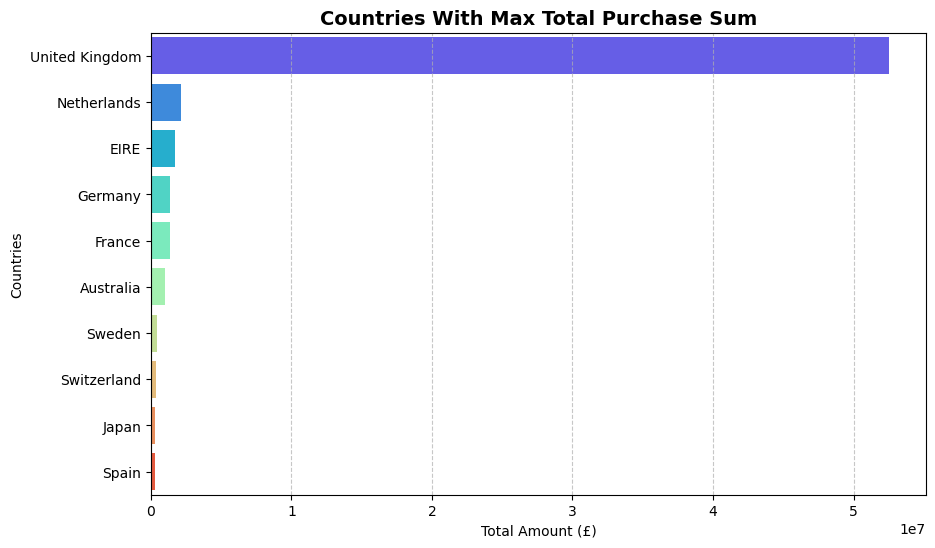

In [139]:
# Calculate total purchases per country
retail_countries_purchase = df_merge.groupby(['Country'], as_index=False)['total_revenue'].agg('sum')
retail_countries_purchase_desc = retail_countries_purchase.sort_values('total_revenue', ascending=False).head(10)

# Visualize the result
plt.figure(figsize=(10, 6))
sns.barplot(
    data=retail_countries_purchase_desc, 
    x='total_revenue', 
    y='Country', 
    palette='rainbow'
)

# Title & label
plt.title('Countries With Max Total Purchase Sum', fontsize=14, fontweight='bold')
plt.xlabel('Total Amount (£)')
plt.ylabel('Countries')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

# Countries with Lowest Transaction Value

C:\Users\benny\AppData\Local\Temp\ipykernel_16128\318420758.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


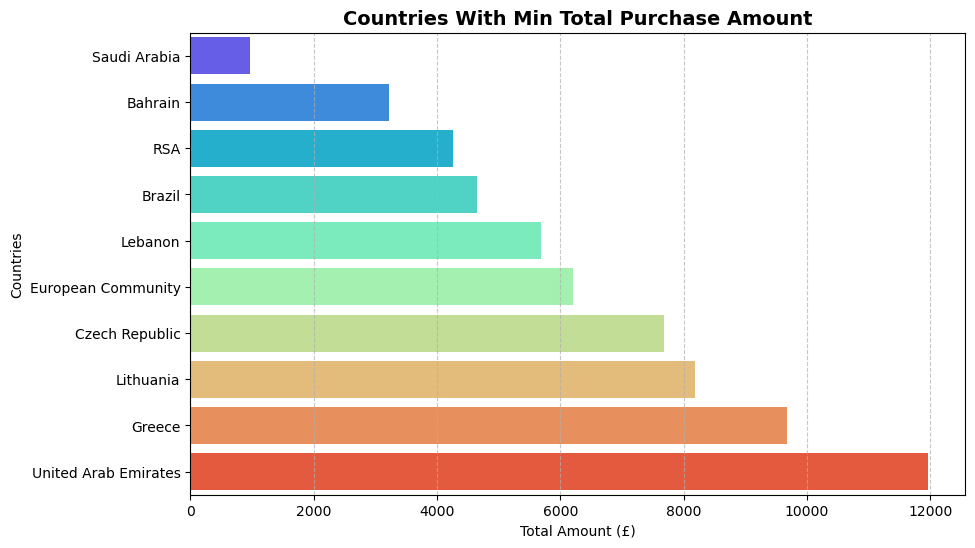

In [141]:
# Visualize the result
plt.figure(figsize=(10, 6))
sns.barplot(
    data=retail_countries_purchase_asc, 
    x='total_revenue', 
    y='Country', 
    palette='rainbow'
)

# Title & label
plt.title('Countries With Min Total Purchase Amount', fontsize=14, fontweight='bold')
plt.xlabel('Total Amount (£)')
plt.ylabel('Countries')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

# Monthly Revenue per Customer Category

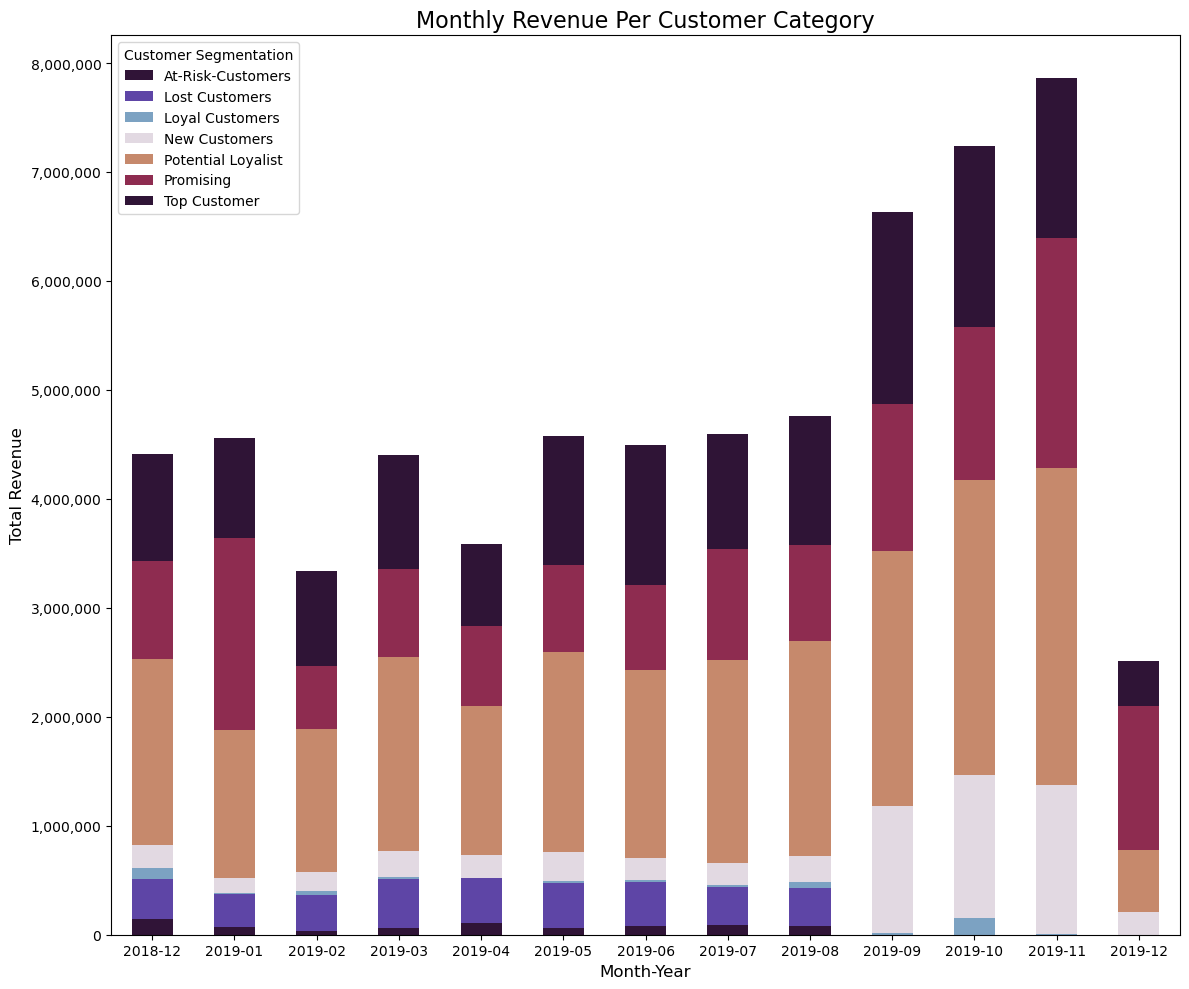

In [143]:
# Daily revenue by customer category
monthly_revenue_category = df_merge.groupby(['order_month', 'Final_Customer_Category'])['total_revenue'].sum().unstack()

# Visualization
# Plot stacked bar chart
monthly_revenue_category.plot(kind='bar', stacked=True, figsize=(12, 10), colormap='twilight_shifted')
plt.title('Monthly Revenue Per Customer Category', fontsize=16)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.legend(title='Customer Segmentation')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
# plt.savefig('Monthly Revenue per Customer Category.png')
plt.show()

# Monthly Revenue per Product Category

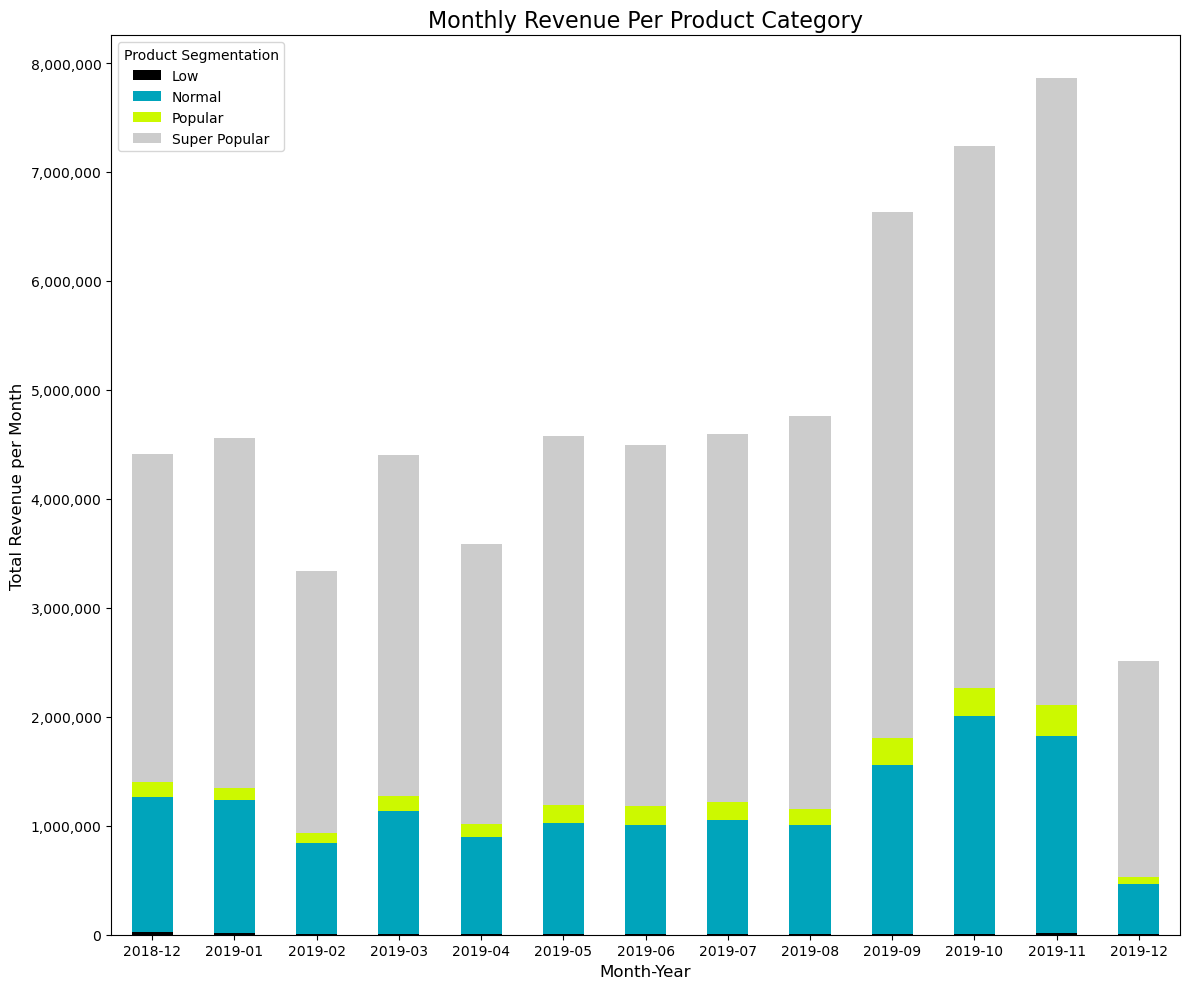

In [145]:
# Daily revenue based on customer category
monthly_revenue_product_category = df_merge.groupby(['order_month', 'final_product_segmentation'])['total_revenue'].sum().unstack()

# Visualization
# Plot stacked bar chart
monthly_revenue_product_category .plot(kind='bar', stacked=True, figsize=(12, 10), colormap='nipy_spectral')
plt.title('Monthly Revenue Per Product Category', fontsize=16)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Total Revenue per Month', fontsize=12)
plt.legend(title='Product Segmentation')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
# plt.savefig('Monthly Revenue per Product Category.png')
plt.show()

# Monthly Average Basket Size per Product Category

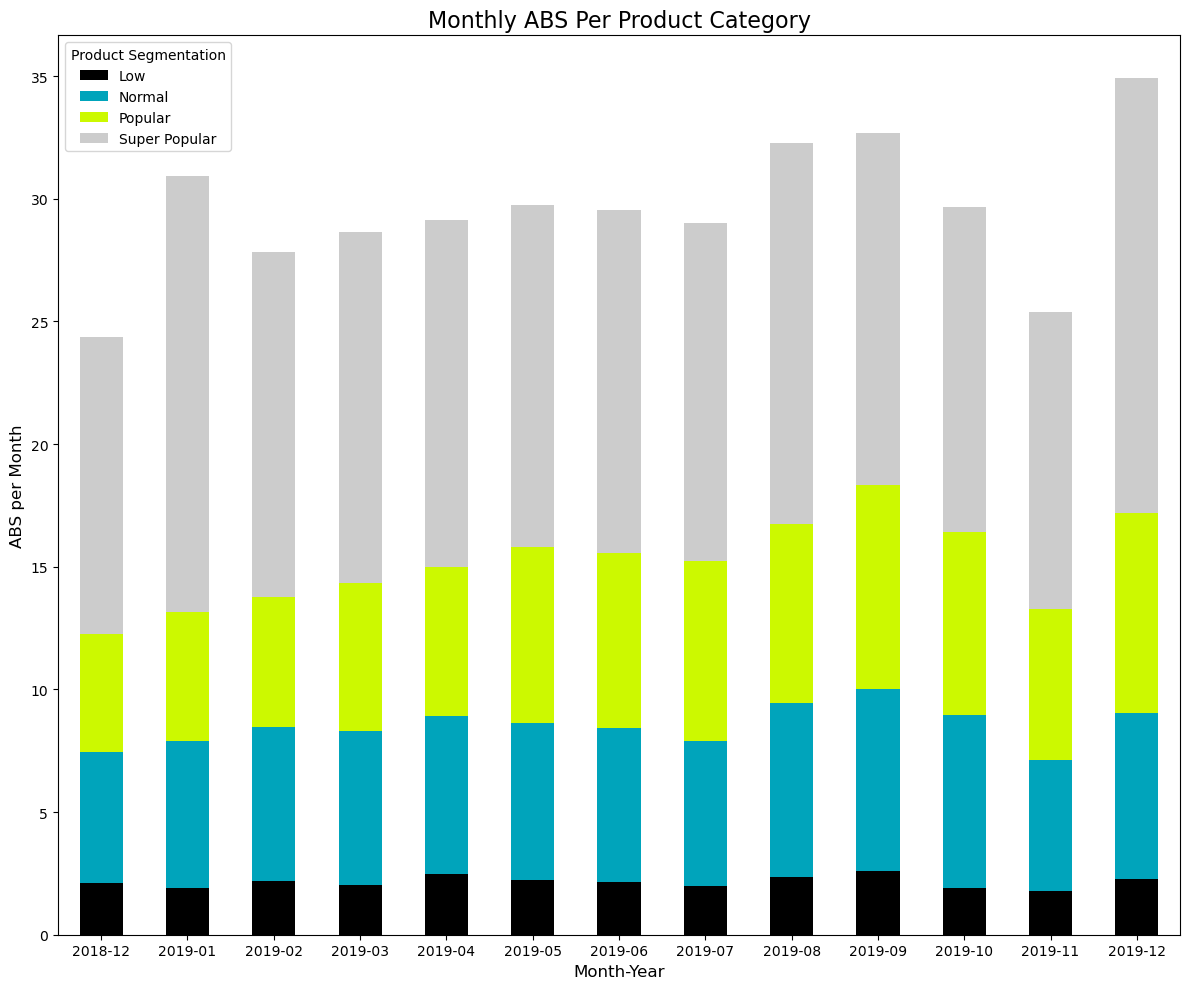

In [147]:
# Average Basket Size per product category
basket_size_product_category = df_merge.groupby(['order_month','final_product_segmentation'])['Quantity'].mean().unstack()

# Visualization
# Plot stacked bar chart
basket_size_product_category.plot(kind='bar', stacked=True, figsize=(12, 10), colormap='nipy_spectral')
plt.title('Monthly ABS Per Product Category', fontsize=16)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('ABS per Month', fontsize=12)
plt.legend(title='Product Segmentation')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

# Monthly Average Basket Size per Customer Category

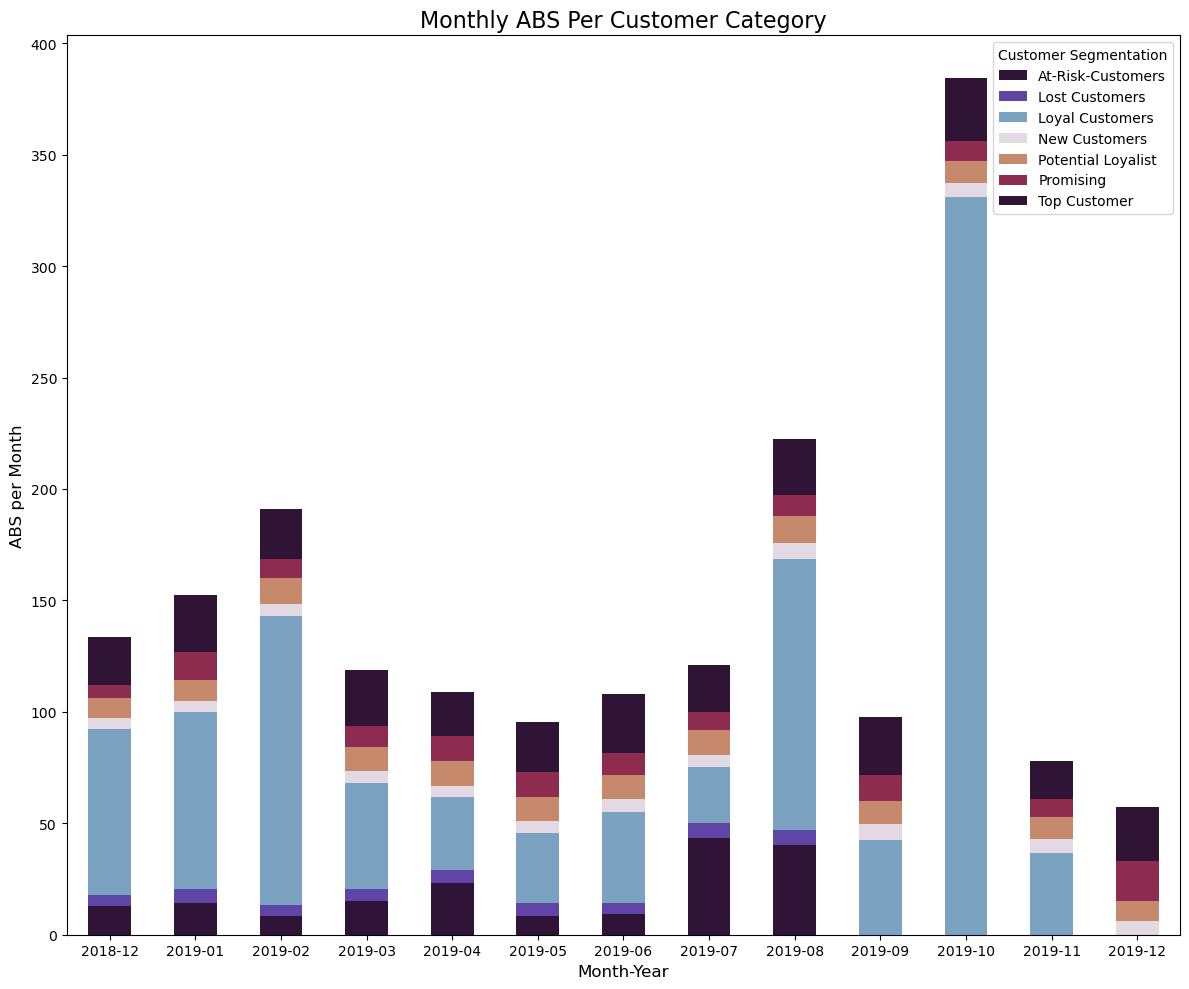

In [149]:
# Average Basket Size per customer category
basket_size_customer_category = df_merge.groupby(['order_month','Final_Customer_Category'])['Quantity'].mean().unstack()

# Visualization
# Plot stacked bar chart
basket_size_customer_category.plot(kind='bar', stacked=True, figsize=(12, 10), colormap='twilight_shifted')
plt.title('Monthly ABS Per Customer Category', fontsize=16)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('ABS per Month', fontsize=12)
plt.legend(title='Customer Segmentation')
plt.xticks(rotation=0)
# plt.savefig('Monthly ABS per Product Category.png')
plt.tight_layout()
plt.show()

# Price Elasticity by Country

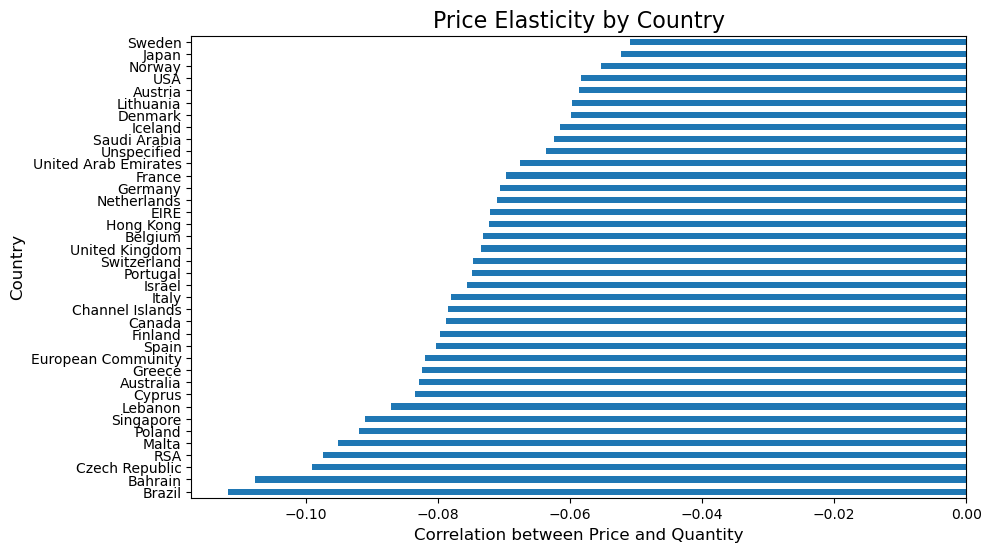

In [151]:
# Correlation between price and quantity by country
price_quantity_correlation = df_merge.groupby('Country')['price_quantity_correlation'].mean()

# Visualization
price_quantity_correlation.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Price Elasticity by Country', fontsize=16)
plt.xlabel('Correlation between Price and Quantity', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.show()

## Monthly Customer Transactions

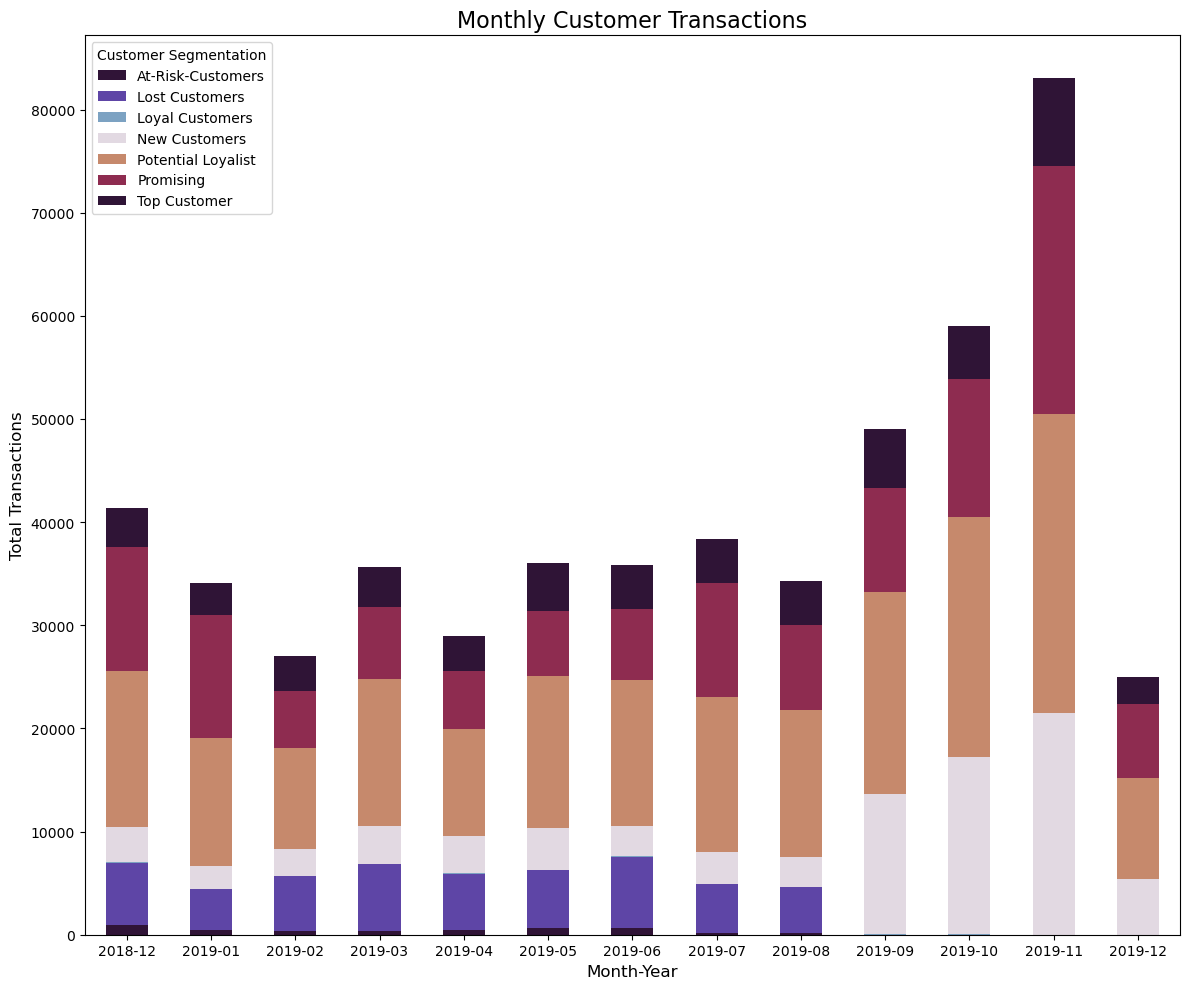

In [153]:
# Number of customers per category over time
monthly_customer_transaction = df_merge.groupby(['order_month', 'Final_Customer_Category']).size().unstack()

# Visualization
# Plot stacked bar chart
monthly_customer_transaction.plot(kind='bar', stacked=True, figsize=(12, 10), colormap='twilight_shifted')
plt.title('Monthly Customer Transactions', fontsize=16)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Total Transactions', fontsize=12)
plt.legend(title='Customer Segmentation')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Number of Customers per Month

<Figure size 1400x800 with 0 Axes>

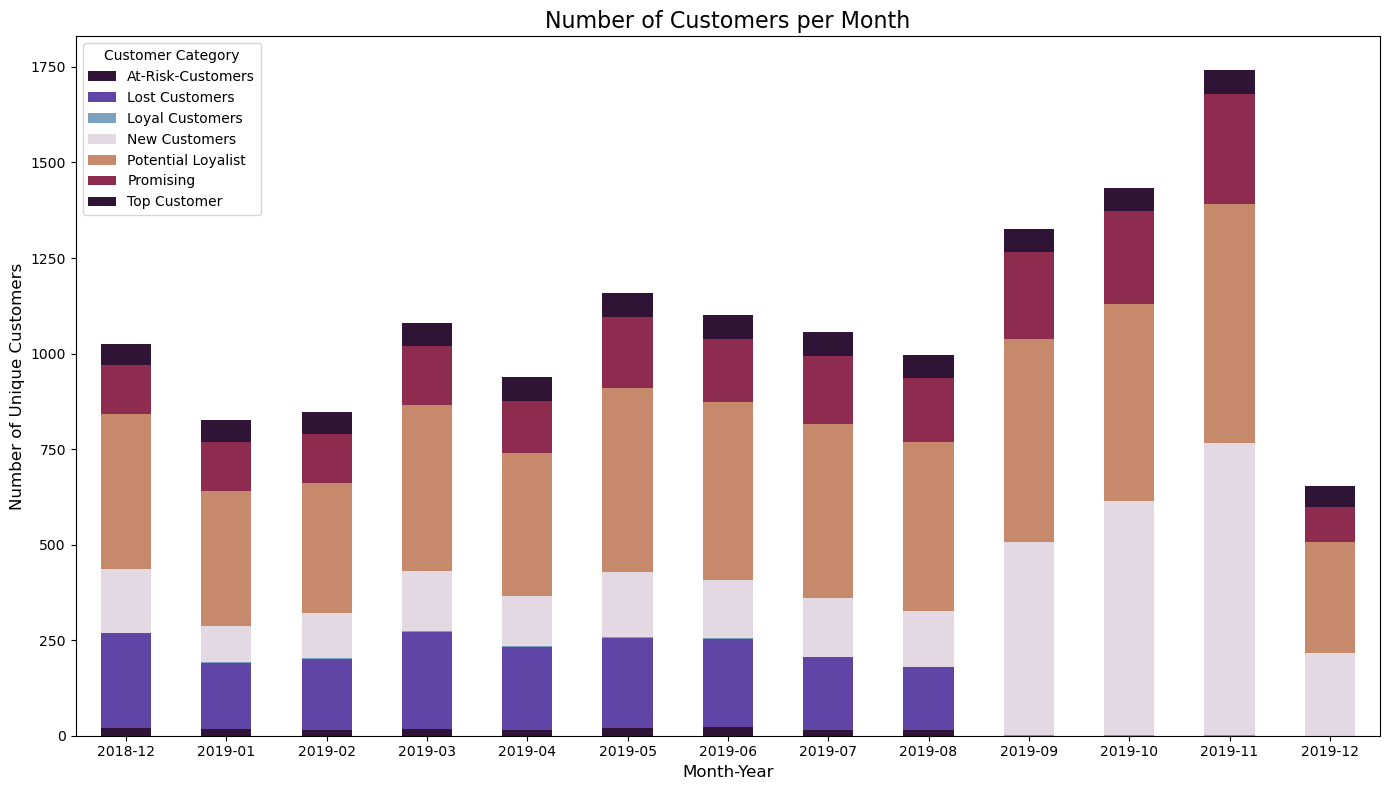

In [155]:
# Calculate the number of customer categories per month with CustomerNo nunique
monthly_unique_customer_category = df_merge.groupby(['order_month', 'Final_Customer_Category'])['CustomerNo'].nunique().reset_index()

# Pivot table is used to create stacked bar plots
pivot_customer_category = monthly_unique_customer_category.pivot_table(index='order_month', columns='Final_Customer_Category', values='CustomerNo', aggfunc='sum', fill_value=0)

# Visualization
plt.figure(figsize=(14, 8))
pivot_customer_category.plot(kind='bar', stacked=True, colormap='twilight_shifted', figsize=(14, 8))
plt.title('Number of Customers per Month', fontsize=16)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Number of Unique Customers', fontsize=12)
plt.legend(title='Customer Category')
plt.xticks(rotation=0)
# plt.savefig('Number of Customers per Month.png')
plt.tight_layout()

plt.show()

# Quantity Sold per Month

<Figure size 1400x800 with 0 Axes>

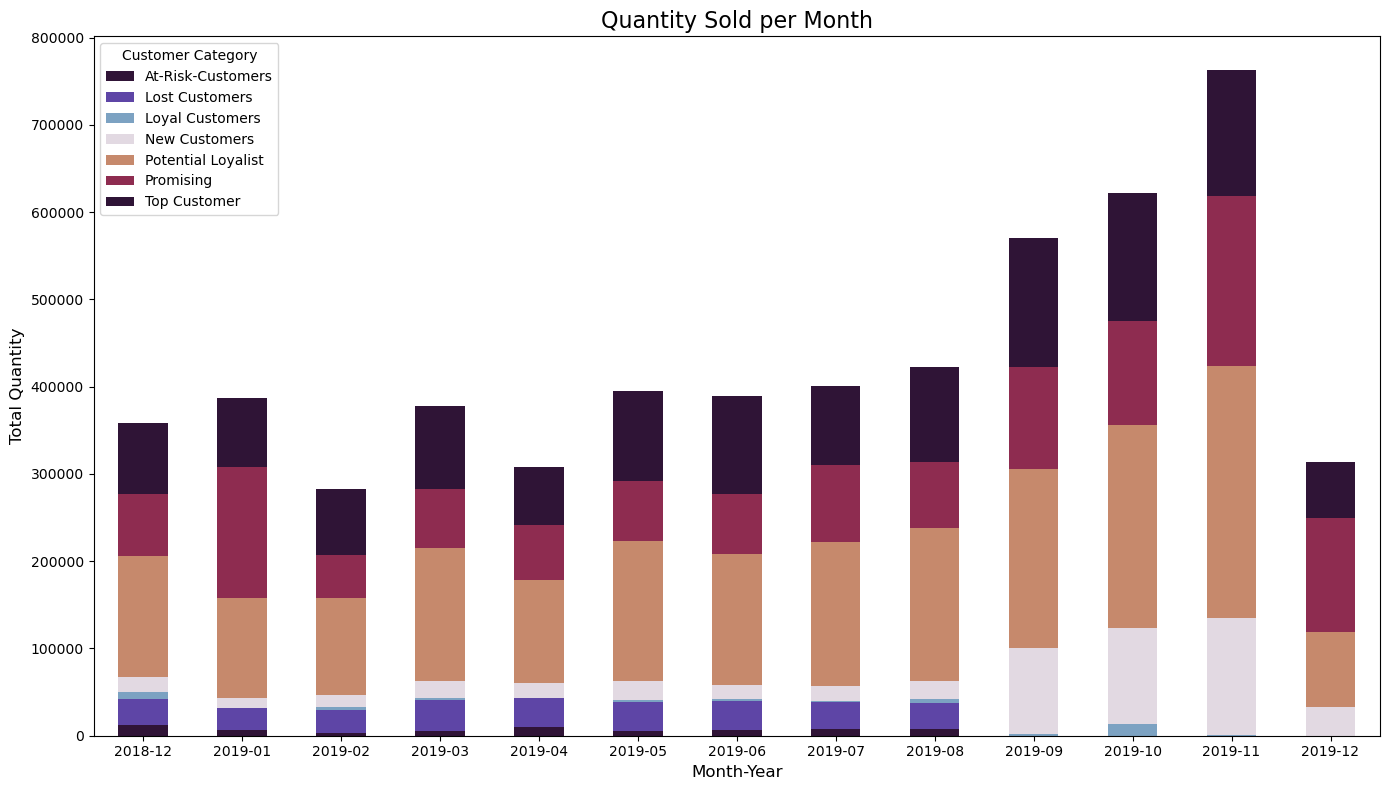

In [157]:
# Calculate sales quantity per month
monthly_transaction_quantity = df_merge.groupby(['order_month', 'Final_Customer_Category'])['Quantity'].sum().unstack()

# Visualization
plt.figure(figsize=(14, 8))
monthly_transaction_quantity.plot(kind='bar', stacked=True, colormap='twilight_shifted', figsize=(14, 8))
plt.title('Quantity Sold per Month', fontsize=16)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Total Quantity', fontsize=12)
plt.legend(title='Customer Category')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# (Crucial Question) Question 5: Based on your findings, what strategy could you recommend to the business to gain more profit?
### From the analysis of customer category performance, the following answers can be obtained:

## **Conclusion Using SWOT Analysis**  

### **Strengths:**  
1. **Potential Loyalist customers contribute the most** to overall performance.  
2. **Loyal Customers have the highest Average Basket Size (ABS)** among all customer categories.  
3. **Increase in New Customers since September 2019.**  
4. **Overall performance has improved** toward the end of the year.  

### **Weaknesses:**  
1. **The number of Lost Customers remained consistent** from Q1 to Q3.  
2. **Loyal Customers are few in number,** despite having the highest ABS compared to other customer categories.  
3. **Poor retention rates throughout 2019.**  

### **Opportunities:**  
1. **Enhancing the loyalty** of Potential Loyalist customers.  
2. **Reactivating Lost Customers.**  
3. **Maximizing the holiday season.**  
4. **Sustaining the momentum** of new customer growth at the end of the year.  

### **Threats:**  
1. **Competition from rivals.**  
2. **High churn rate from December 2018 to August 2019.**  
3. **Performance fluctuations throughout the year.**  
4. **Indications of dependency on seasonal revenue.**  

## **Recommendations**  

The recommendations are divided into three categories based on the period: **General Recommendations** (applicable from Q1 to Q4), **Recommendations for Q1–Q3**, and **Recommendations for Q4**.  

### **In General:**  
1. **Focus marketing strategies on Potential Loyalist and Promising customers**, as these categories contribute significantly to sales. The initial strategy should aim to **increase shopping frequency and Average Basket Size (ABS)** to drive higher total revenue. **Bundling promotions and loyalty programs** can be used to enhance both frequency and ABS. If these two customer segments increase their frequency and ABS, they are expected to **move up to the Loyal Customers category**.  
2. **For existing Loyal Customers, the goal is to increase their shopping frequency** by offering **discount promotions**, which can be combined with **Super Popular products** for each season to enhance purchase motivation. By implementing these strategies, **Loyal Customers are expected to transition into Top Customers**.  

### **Q1–Q3 Period:**  
1. **Develop strategies to address Lost Customers and improve customer retention** during Q1 to Q3. This can be done by offering **incentive-based promotions targeted at Lost Customers**, along with a **customer feedback mechanism** to understand why they have stopped purchasing. This approach serves **two purposes**:  
   - **Reactivating Lost Customers**  
   - **Gathering valuable feedback** to improve future services and reduce the number of Lost Customers in Q1–Q3.  
2. **Diversify and enhance sales strategies in Q1–Q3** to **increase revenue throughout the year**, rather than relying solely on year-end sales growth. The goal is to **surpass the revenue performance of the first three quarters compared to the previous year**.  

### **Q4 Period:**  
1. **Leverage the strong performance of Q4 2019** by developing an even more **refined marketing strategy for Q4 2020** to **maximize revenue**. The initial focus should be on **replicating the successful strategies from Q4 2019**, which **increased New Customers and reduced Lost Customers**. From there, the marketing and sales teams can **further enhance the strategy with additional innovative ideas**.  
2. **Beyond marketing strategies for revenue maximization in Q4, it is crucial to prepare for competition**—both domestic and international. In addition to **product price promotions**, **shipping cost promotions** can also be introduced to **maintain and increase international sales**.

## To develop a strategy that focuses on customer categories Potential Loyalists, Promising customers, Loyal Customers and Lost Customers, then I'll provide some guidelines that can be used while planning the strategies.
The guidelines are as follows:
1. Information on superior product categories and top 5 products per season.
2. Seasonality analysis
3. Country of origin where the 4 customer categories to be focused are located
4. Forecasting to become the company's target in 2020

## Analysis below is a complementary analysis that can be used as guidelines for implementing the strategy resulting from the SWOT Analysis:

## Highest Revenue per Product Category on each Customer Category 

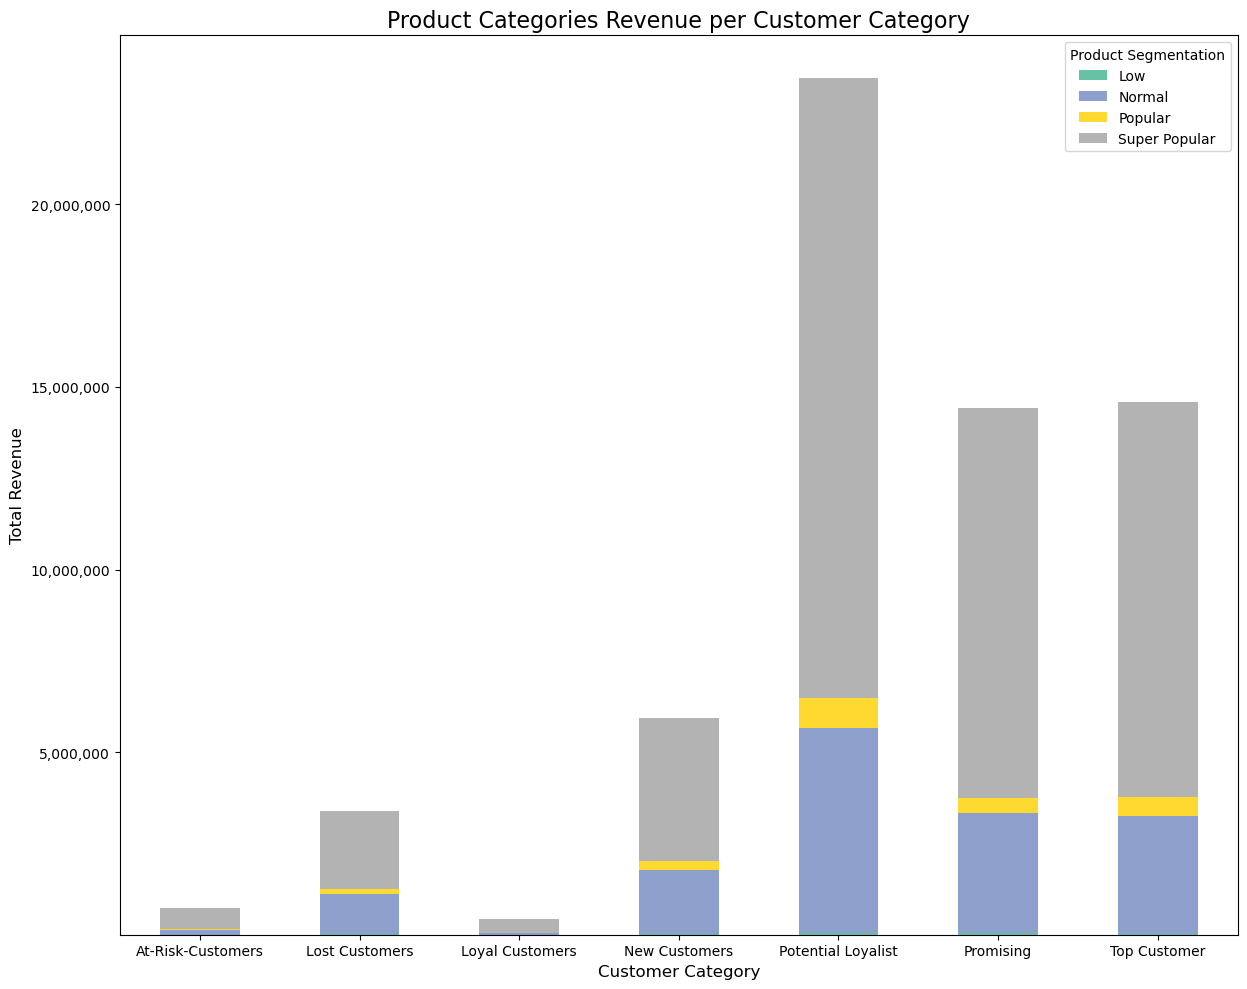

In [164]:
# Counting the number of product categories per customer category
product_category_revenue_per_customer = df_merge.groupby(['Final_Customer_Category', 'final_product_segmentation'])['total_revenue'].sum().unstack()

# Visualization
# Plot stacked bar chart
product_category_revenue_per_customer.plot(kind='bar', stacked=True, figsize=(12, 10), colormap='Set2')
plt.title('Product Categories Revenue per Customer Category', fontsize=16)
plt.xlabel('Customer Category', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.legend(title='Product Segmentation')
plt.xticks(rotation=0)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

### Insight from the number of products per category in each customer category:
1. Because we want to focus on customer categories, namely Potential Loyalists, Promising Customers, Loyal Customers and Lost Customers, then to support the marketing and sales strategies that we will run, we can find out which product categories are suitable to use in promo campaigns that target the 4 customer categories that are our focus.
2. From the results of the analysis above, it is certain that the Super Popular category product is the most suitable because it generates the most revenue for the customer category that is our focus.

## Top 5 Countries with Highest Number of Focused Customer Categories (Potential Loyalists, Promising Customers, Loyal Customers & Lost Customers)

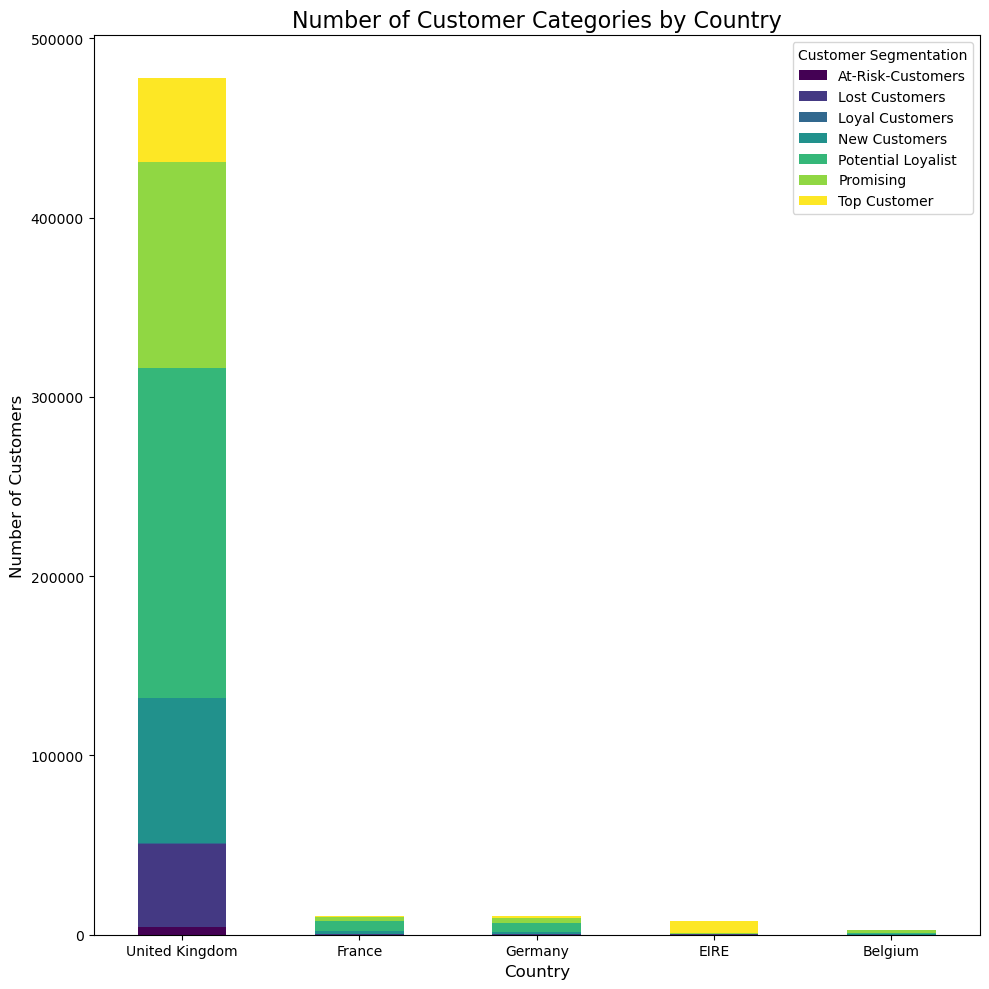

In [167]:
# Count the number of product categories by country
customer_categories_per_country_stacked = df_merge.groupby(['Country', 'Final_Customer_Category']).size().unstack(fill_value=0)

# Sorted by total number of product categories in each country
customer_categories_per_country_stacked['Total'] = customer_categories_per_country_stacked.sum(axis=1)
customer_categories_per_country_stacked = customer_categories_per_country_stacked.sort_values(by='Total', ascending=False)
customer_categories_per_country_stacked = customer_categories_per_country_stacked.drop(columns=['Total']).head()

# Visualization
customer_categories_per_country_stacked.plot(kind='bar', stacked=True, figsize=(10, 10), colormap='viridis')
plt.title('Number of Customer Categories by Country', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Customer Segmentation')
plt.tight_layout()
# plt.savefig('Number of Customer Categories by Country.png')
plt.show()

### Insight from the analysis of the Top 5 countries with the highest number of transactions based on customer category:
1. The 4 customer categories that we gonna focus on, mostly come from the United Kingdom
2. It can be concluded that the United Kingdom is the domestic country or retail store's origin country

# Adding Seasons Label

In [170]:
# Function to categorize seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

# Add season column
df_merge['Season'] = df_merge['Date'].dt.month.map(get_season)
df_merge

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,total_revenue,order_month,cohort,DayOfWeek,DayName,Final_Customer_Category,final_product_segmentation,price_quantity_correlation,Season
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,257.64,2019-12,2019-06,0,Monday,Potential Loyalist,Normal,NaN,Winter
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,383.40,2019-12,2018-12,0,Monday,Potential Loyalist,Super Popular,-0.040087,Winter
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,138.36,2019-12,2018-12,0,Monday,Potential Loyalist,Normal,NaN,Winter
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,127.80,2019-12,2018-12,0,Monday,Potential Loyalist,Normal,NaN,Winter
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,71.64,2019-12,2018-12,0,Monday,Potential Loyalist,Normal,-0.068136,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527760,536585,2018-12-01,37449,Ceramic Cake Stand + Hanging Cakes,20.45,2,17460.0,United Kingdom,40.90,2018-12,2018-12,5,Saturday,Potential Loyalist,Normal,NaN,Winter
527761,536590,2018-12-01,22776,Sweetheart 3 Tier Cake Stand,20.45,1,13065.0,United Kingdom,20.45,2018-12,2018-12,5,Saturday,Lost Customers,Popular,-0.076276,Winter
527762,536590,2018-12-01,22622,Box Of Vintage Alphabet Blocks,20.45,2,13065.0,United Kingdom,40.90,2018-12,2018-12,5,Saturday,Lost Customers,Popular,-0.133043,Winter
527763,536591,2018-12-01,37449,Ceramic Cake Stand + Hanging Cakes,20.45,1,14606.0,United Kingdom,20.45,2018-12,2018-12,5,Saturday,Top Customer,Normal,NaN,Winter


# Seasonality Analysis

## Total Revenue per Season

C:\Users\benny\AppData\Local\Temp\ipykernel_16128\2302145665.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=revenue_per_season.index, y=revenue_per_season.values, palette=season_colors)


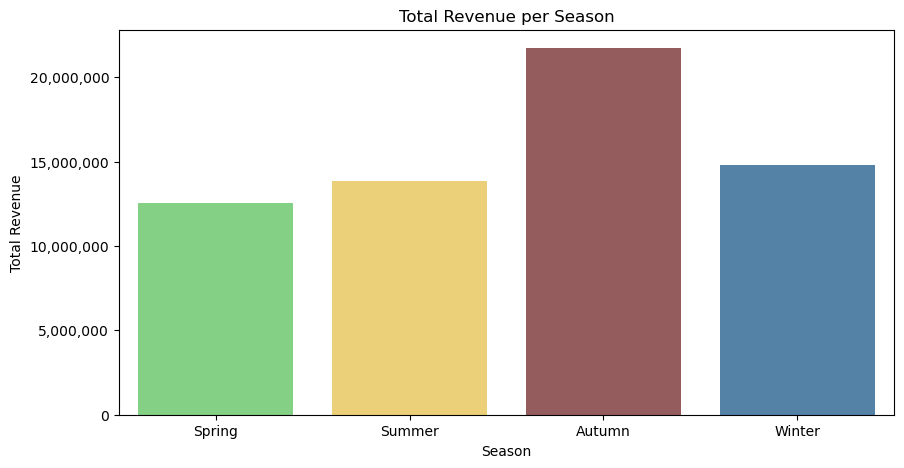

In [173]:
# Total revenue per season
revenue_per_season = df_merge.groupby('Season')['total_revenue'].sum()
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
season_colors = ["#77DD77", "#FFD966", "#9F5255", "#4682B4"] 
revenue_per_season = revenue_per_season.reindex(season_order)

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x=revenue_per_season.index, y=revenue_per_season.values, palette=season_colors)
plt.title('Total Revenue per Season')
plt.xlabel('Season')
plt.ylabel('Total Revenue')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

## Analisis total kuantitas transaksi per Season

C:\Users\benny\AppData\Local\Temp\ipykernel_16128\433170354.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=quantity_per_season.index, y=quantity_per_season.values, palette=season_colors)


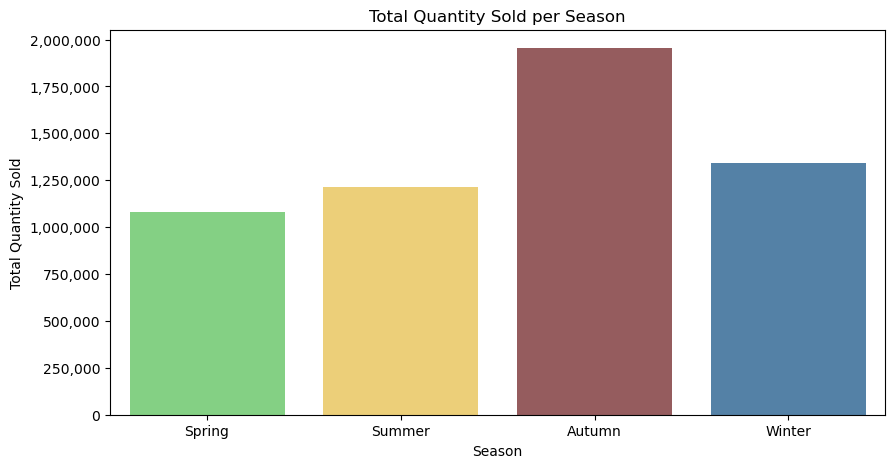

In [175]:
# Number of products sold per Season
quantity_per_season = df_merge.groupby('Season')['Quantity'].sum()
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
season_colors = ["#77DD77", "#FFD966", "#9F5255", "#4682B4"] 
quantity_per_season = quantity_per_season.reindex(season_order)

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x=quantity_per_season.index, y=quantity_per_season.values, palette=season_colors)
plt.title('Total Quantity Sold per Season')
plt.xlabel('Season')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

### Conclusion:
Autumn season (September, October, November) is the most profitable season.

## Top 5 Product per Season

C:\Users\benny\AppData\Local\Temp\ipykernel_16128\1878044623.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_5_products = top_products_per_season.groupby('Season').head(5)


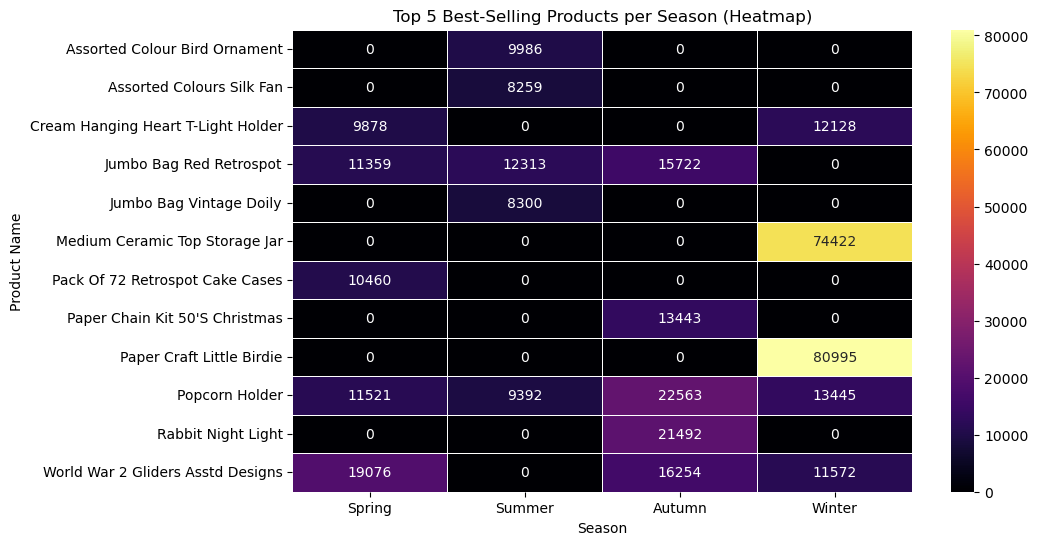

In [178]:
# Top 5 Best Selling Products in each Season
top_products_per_season = df_merge.groupby(['Season', 'ProductName'])['Quantity'].sum().reset_index()

# Sorting Seasons in visualization
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
top_products_per_season['Season'] = pd.Categorical(top_products_per_season['Season'], categories=season_order, ordered=True)

# Sort by Season and Quantity
top_products_per_season = top_products_per_season.sort_values(['Season', 'Quantity'], ascending=[True, False])

# Take top 5 products of each season
top_5_products = top_products_per_season.groupby('Season').head(5)

# Visualization of best-selling products in each season
heatmap_data = top_5_products.pivot(index='ProductName', columns='Season', values='Quantity').fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='inferno', fmt='.0f', linewidths=0.5)
plt.title('Top 5 Best-Selling Products per Season (Heatmap)')
plt.xlabel('Season')
plt.ylabel('Product Name')
# plt.savefig('Top 5 Best-Selling Products per Season.png')
plt.show()

### **Background Data:**  
To leverage **Super Popular products** in marketing strategies, the **Top 5 Best-Selling Products per Season** can be utilized.  

### **Insights:**  
1. **Marketing campaign strategies can incorporate the Top 5 Products from each season** listed in the chart to enhance the success rate of upcoming campaigns.  

2. **Example Strategies:**  
   - **Assorted Colour Bird Ornament, Assorted Colours Silk Fan, and Jumbo Bag Vintage Dolly** rank among the **Top 5 products exclusively in the Summer season**. This indicates that their sales are highly **seasonal-dependent**. Therefore, these products should only be **utilized during Summer** to ensure that marketing campaigns in other seasons remain optimized.  
   - **Popcorn Holder** is suitable for **all seasons**, so it is essential to **maintain adequate stock availability throughout the year**.  
   - **Medium Ceramic Top Storage Jar and Paper Craft Little Birdie**, which are highly popular during **Winter**, should be prioritized to ensure sufficient stock availability to meet demand during the **Winter season**.

**Note**: **Papercraft Little Birdie** which sold over 80k pcs occurred from a one time purchase from 1 customer in December 2019.

## Seasonality Analysis: Combining seasonality analysis per season, per month dan per day

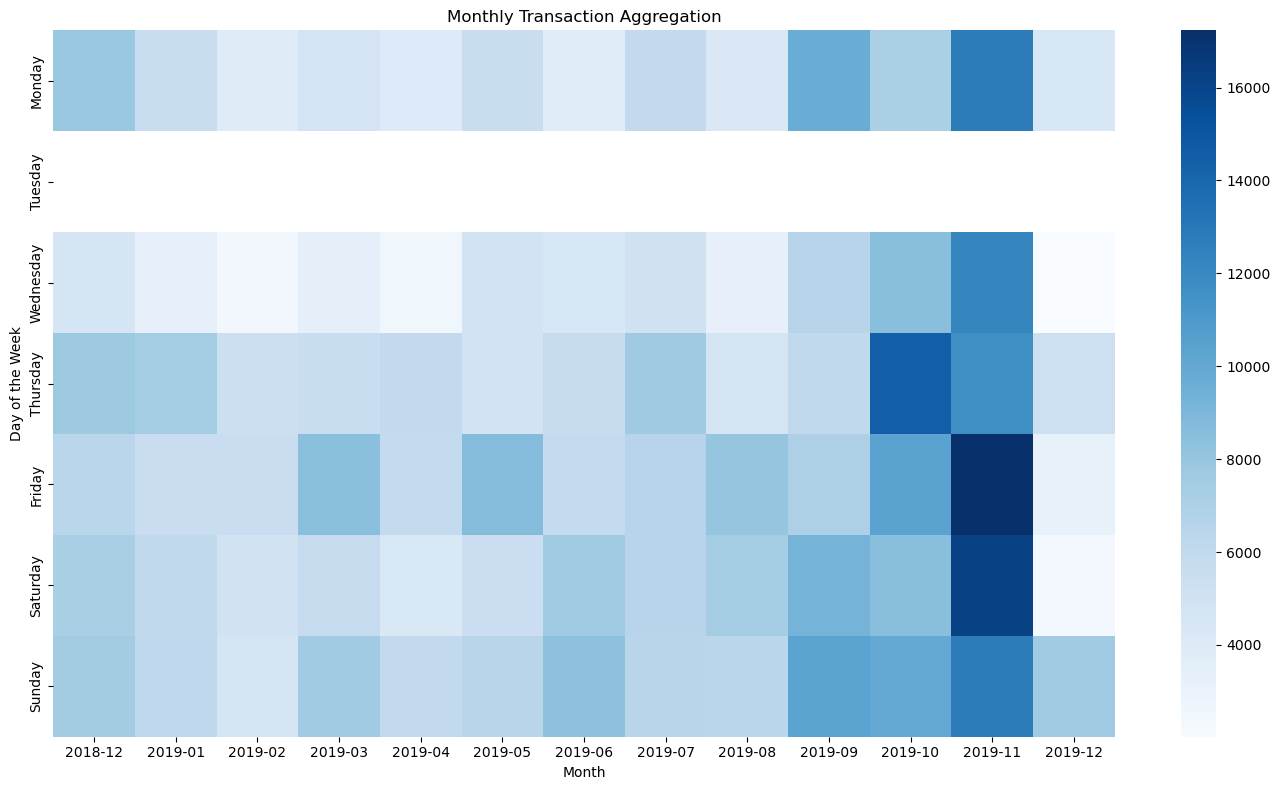

In [181]:
# Analysis of total transactions per month and per day
heatmap_data = df_merge.groupby(['DayName', 'order_month']).size().unstack(fill_value=0)

# Sort the days in the correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(day_order)

# Visualize the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap='Blues', annot=False, cbar=True)
plt.title('Monthly Transaction Aggregation')
plt.xlabel('Month')
plt.ylabel('Day of the Week')
plt.tight_layout()
# plt.savefig('Heatmap Transaction per Month and per Day.png')
plt.show()

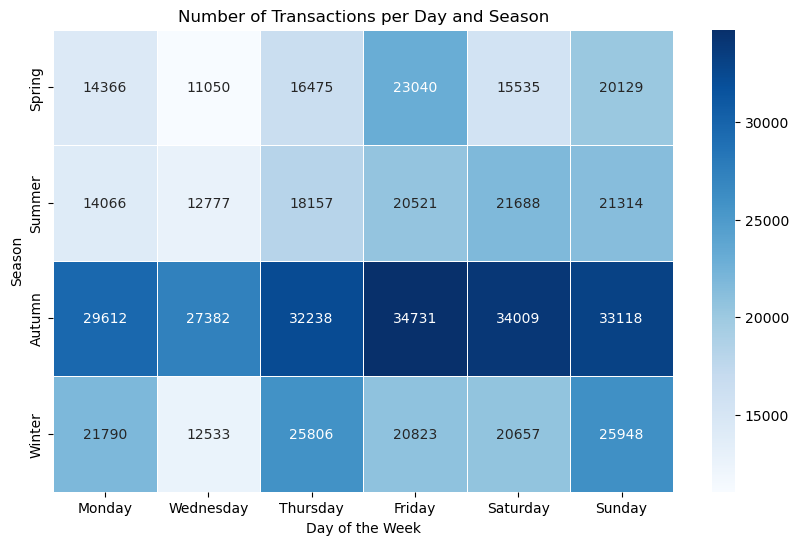

In [182]:
### Analyze the number of transactions per day in each season ###

# Determine the desired order of seasons and days of the week
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
day_order = ['Monday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Average transactions by day of the week in each season
transactions_per_day_season = df_merge.groupby(['Season', 'DayName']).size().unstack()

# Sort the seasons in the desired order
transactions_per_day_season = transactions_per_day_season.reindex(season_order)

# Sort the days of the week in the desired order
transactions_per_day_season = transactions_per_day_season[day_order]

# Visualization: Heatmap to see the relationship between day and season and number of transactions
plt.figure(figsize=(10, 6))
sns.heatmap(transactions_per_day_season, annot=True, cmap='Blues', fmt='d', linewidths=0.5)
plt.title('Number of Transactions per Day and Season')
plt.xlabel('Day of the Week')
plt.ylabel('Season')
# plt.savefig('Number of Transactions per Day and Season.png')
plt.show()

### Background data:
Heatmap to show customers' shopping behavior for 1 year.

### Insight:
1. This data can be used as a reference for the right time to run a marketing campaign strategy each month.
2. The most prominent example in November on Friday, the number of transactions during that month reached 16,000, meaning that per week there could be 4,000 transactions on every Friday. So Friday in November 2020 could be the most appropriate time to run all types of promotions to generate the highest transactions.

## Price Sensitivity per Season

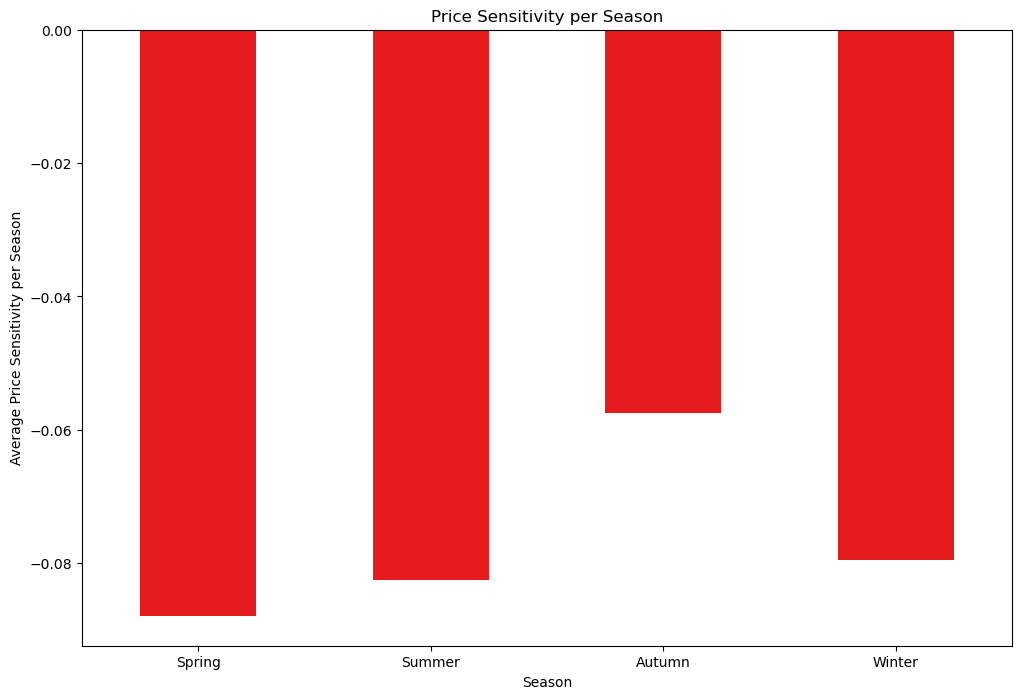

In [185]:
# Number of transactions in each product category per season
price_sensitivity_per_season = df_merge.groupby('Season')['price_quantity_correlation'].mean()
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
price_sensitivity_per_season = price_sensitivity_per_season.reindex(season_order)

# Visualization
price_sensitivity_per_season.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='Set1')
plt.title('Price Sensitivity per Season')
plt.xlabel('Season')
plt.ylabel('Average Price Sensitivity per Season')
plt.xticks(rotation=0)
# plt.savefig('Price Sensitivity per Season.png')
plt.show()

## Analysis: Price Sensitivity Data Distribution
Dari hasil pengecekan bisa disimpulkan bahwa penyebaran nilai koefisien korelasi antara Price dan Quantity banyak di sekitar -0.1 sampai 0, artinya banyak produk yang bila harganya meningkat maka akan terjadi penurunan kuantitas penjualan, biarpun efek penurunannya tidak terlalu besar karena nilai minus korelasinya hanya sekitar -0.1 sampai -0.45.

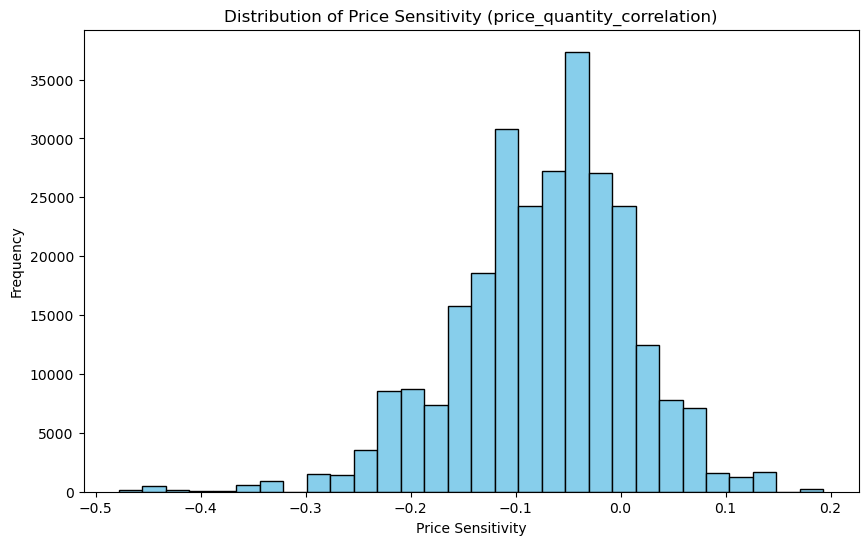

In [187]:
# Visualization: Histogram to see the distribution of 'price_quantity_correlation'
plt.figure(figsize=(10, 6))
plt.hist(df_merge['price_quantity_correlation'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Price Sensitivity (price_quantity_correlation)')
plt.xlabel('Price Sensitivity')
plt.ylabel('Frequency')
plt.show()

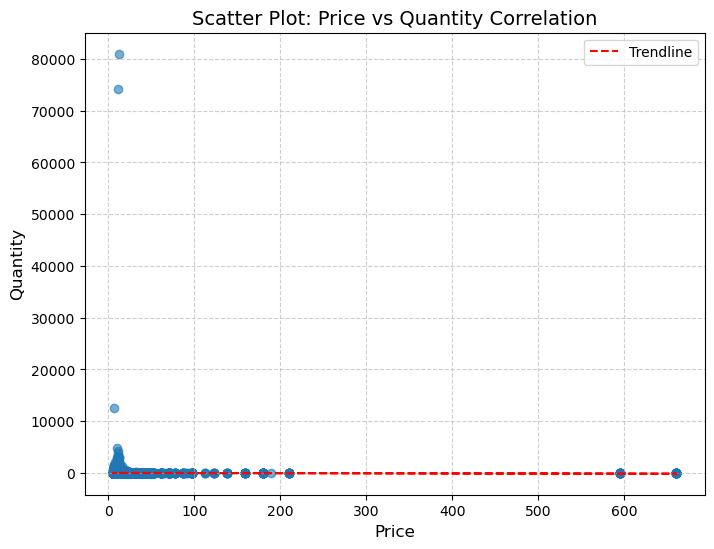

In [188]:
# View Price vs Qty correlation for all products
all_product_data = df_merge[['ProductName', 'Price', 'Quantity']]

# Scatter plot for price and qty correlation
plt.figure(figsize=(8, 6))
plt.scatter(all_product_data['Price'], all_product_data['Quantity'], alpha=0.6)

# Adding trendline
z = np.polyfit(all_product_data['Price'], all_product_data['Quantity'], 1)
p = np.poly1d(z)
plt.plot(all_product_data['Price'], p(all_product_data['Price']), "r--", label="Trendline")
plt.legend()

plt.title(f'Scatter Plot: Price vs Quantity Correlation', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Because most customers comes from United Kingdom and from the previous Top 5 Countries visualization we cannot see the portion of the customer category that is our main focus in other countries. 

### The next analysis is intended to see which country has the largest number of customers from the customer category that we want to focus on.

In [190]:
# Filter data by country and Final_Customer_Category
df_customer_focus = df_merge[(df_merge['Country'] != 'United Kingdom') & 
                 (df_merge['Final_Customer_Category'].isin(['Potential Loyalist', 'Promising', 'Loyal Customers', 'Lost Customers']))]

# Counting the number of customers by country and customer category
customer_counts = df_customer_focus.groupby(['Country', 'Final_Customer_Category']).size().reset_index(name='Customer Count')
customer_counts

,Country,Final_Customer_Category,Customer Count
0,Australia,Lost Customers,10
1,Australia,Potential Loyalist,1114
2,Australia,Promising,445
3,Austria,Lost Customers,43
4,Austria,Promising,809
...,...,...,...
62,Switzerland,Promising,1401
63,USA,Lost Customers,35
64,USA,Promising,221
65,United Arab Emirates,Lost Customers,30


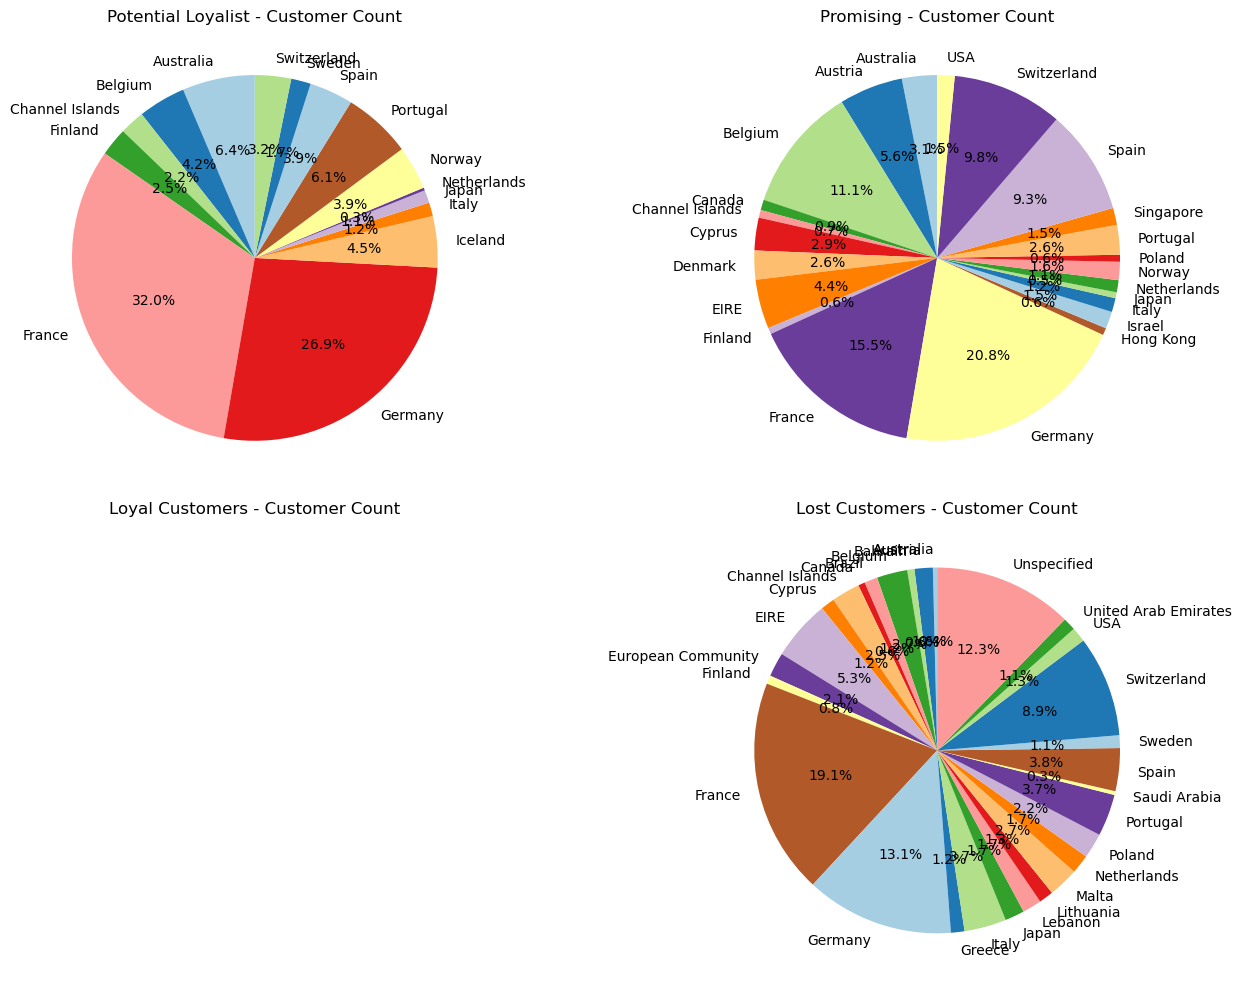

In [191]:
# Filter data by country and Final_Customer_Category
df_customer_focus = df_merge[(df_merge['Country'] != 'United Kingdom') & 
                 (df_merge['Final_Customer_Category'].isin(['Potential Loyalist', 'Promising', 'Loyal Customers', 'Lost Customers']))]

# Counting the number of customers by country and customer category
customer_counts = df_customer_focus.groupby(['Country', 'Final_Customer_Category']).size().reset_index(name='Customer Count')

# Focused customer category
categories = ['Potential Loyalist', 'Promising', 'Loyal Customers', 'Lost Customers']

# Setup subplots for 4 pie charts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, category in enumerate(categories):
    # Filter data for specific customer categories
    category_data = customer_counts[customer_counts['Final_Customer_Category'] == category]
    
    # Visualize in pie chart
    axes[i].pie(category_data['Customer Count'], 
                labels=category_data['Country'], 
                autopct='%1.1f%%', 
                startangle=90, 
                colors=plt.cm.Paired.colors[:len(category_data)])
    axes[i].set_title(f'{category} - Customer Count')

# Showing the pie chart
plt.tight_layout()
# plt.savefig('Customer Count per Country.png')
plt.show()

## Because the previous pice chart a little bit overplotted, so I will only show the Top 5 Countries  with highest percentage in the previous pie chart

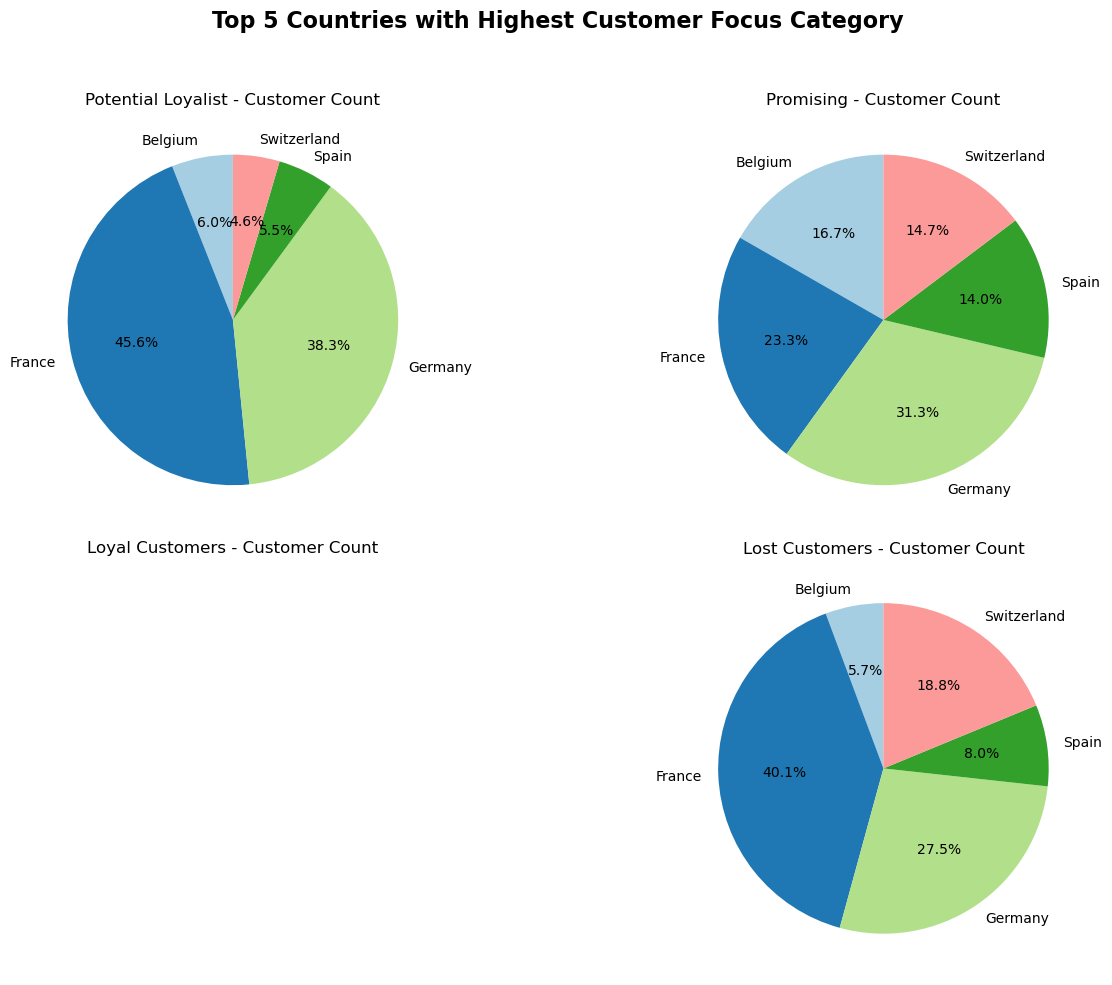

In [193]:
# Filter data by country and Final_Customer_Category
df_customer_focus = df_merge[(df_merge['Country'] != 'United Kingdom') & 
                 (df_merge['Final_Customer_Category'].isin(['Potential Loyalist', 'Promising', 'Loyal Customers', 'Lost Customers']))]

# Counting the number of customers by country and customer category
customer_counts = df_customer_focus.groupby(['Country', 'Final_Customer_Category']).size().reset_index(name='Customer Count')

# Take the 5 countries with the highest number of customers overall
top_countries = customer_counts.groupby('Country')['Customer Count'].sum().nlargest(5).index

# Filter data to only top 5 countries
customer_counts = customer_counts[customer_counts['Country'].isin(top_countries)]

# Focused customer category
categories = ['Potential Loyalist', 'Promising', 'Loyal Customers', 'Lost Customers']

# Setup subplots for 4 pie charts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Top 5 Countries with Highest Customer Focus Category', fontsize=16, fontweight='bold')
axes = axes.flatten()

for i, category in enumerate(categories):
    # Filter data for specific customer categories
    category_data = customer_counts[customer_counts['Final_Customer_Category'] == category]
    
    # Visualize in pie chart
    axes[i].pie(category_data['Customer Count'], 
                labels=category_data['Country'], 
                autopct='%1.1f%%', 
                startangle=90, 
                colors=plt.cm.Paired.colors[:len(category_data)])
    axes[i].set_title(f'{category} - Customer Count')

# Show the visualization
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout so that the title is not covered
plt.show()

# Forecasting 2020 with Prophet model and Controlled Forecasting (add 10% to total revenue per month in 2019)

C:\Users\benny\AppData\Local\Temp\ipykernel_16128\529788800.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df_merge_forecasting['total_revenue'].resample('M').sum()
C:\Users\benny\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\benny\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\benny\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1233: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs

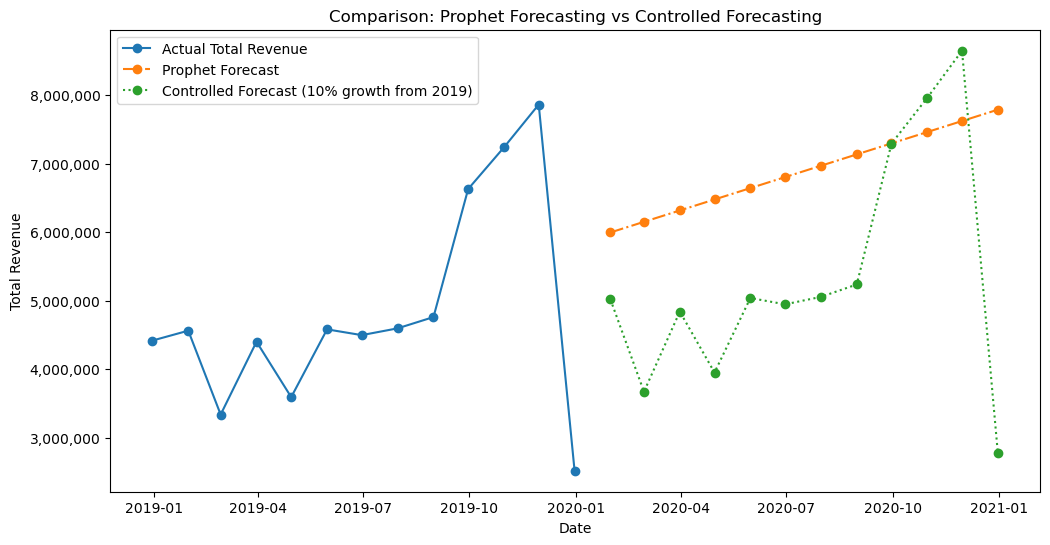

In [195]:
# Make sure the date column is changed to datetime and set as an index
df_merge_forecasting = df_merge.copy() # because the Date column will be used as an index, I copy the dataframe so that the original df does not change and can still be used in further analysis.
df_merge_forecasting['Date'] = pd.to_datetime(df_merge_forecasting['Date'])
df_merge_forecasting.set_index('Date', inplace=True)

# Aggregate total revenue per month
monthly_data = df_merge_forecasting['total_revenue'].resample('M').sum()

# Preparing the SARIMAX model for use in Controlled Forecast
sarimax_model = SARIMAX(monthly_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_model_fit = sarimax_model.fit()

# Preparing data for Prophet
prophet_data = monthly_data.reset_index()
prophet_data.columns = ['ds', 'y']

# Preparing the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Forecast for 12 months in 2020 (Prophet)
future_dates = prophet_model.make_future_dataframe(periods=12, freq='M')
prophet_forecast = prophet_model.predict(future_dates)
prophet_forecast_2020 = prophet_forecast[prophet_forecast['ds'].dt.year == 2020]
prophet_forecast_series = pd.Series(prophet_forecast_2020['yhat'].values, index=prophet_forecast_2020['ds'])

# Forecast for 12 months in 2020 (SARIMAX)
sarimax_forecast_index = pd.date_range(start=monthly_data.index[-1], periods=13, freq='M')[1:]
sarimax_forecast_series = pd.Series(sarimax_model_fit.forecast(steps=12), index=sarimax_forecast_index)

# Controlled Forecast for 12 months in 2020 with an expected 10% increase from total revenue in 2019
average_2019_revenue = monthly_data['2019'].mean()
controlled_forecast = [monthly_data['2019'].iloc[i % 12] * 1.1 for i in range(12)]
controlled_forecast_series = pd.Series(controlled_forecast, index=sarimax_forecast_index)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data, marker='o', label="Actual Total Revenue")
plt.plot(prophet_forecast_series, marker='o', linestyle='dashdot', label="Prophet Forecast")
plt.plot(controlled_forecast_series, marker='o', linestyle='dotted', label="Controlled Forecast (10% growth from 2019)")
plt.legend()
plt.title("Comparison: Prophet Forecasting vs Controlled Forecasting")
plt.xlabel("Date")
plt.ylabel("Total Revenue")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
# plt.savefig('Prophet Forecasting vs Controlled Forecasting.png')
plt.show()